In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
from IPython.display import clear_output
from multiprocessing import Pool
from time import time
import missingno as msno

In [5]:
data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [6]:
df = data.to_dataframe().reset_index().set_index("time")
df = df.sort_index().loc['2022-01-01' : '2022-12-31', :]

df["datetime"] = df.index

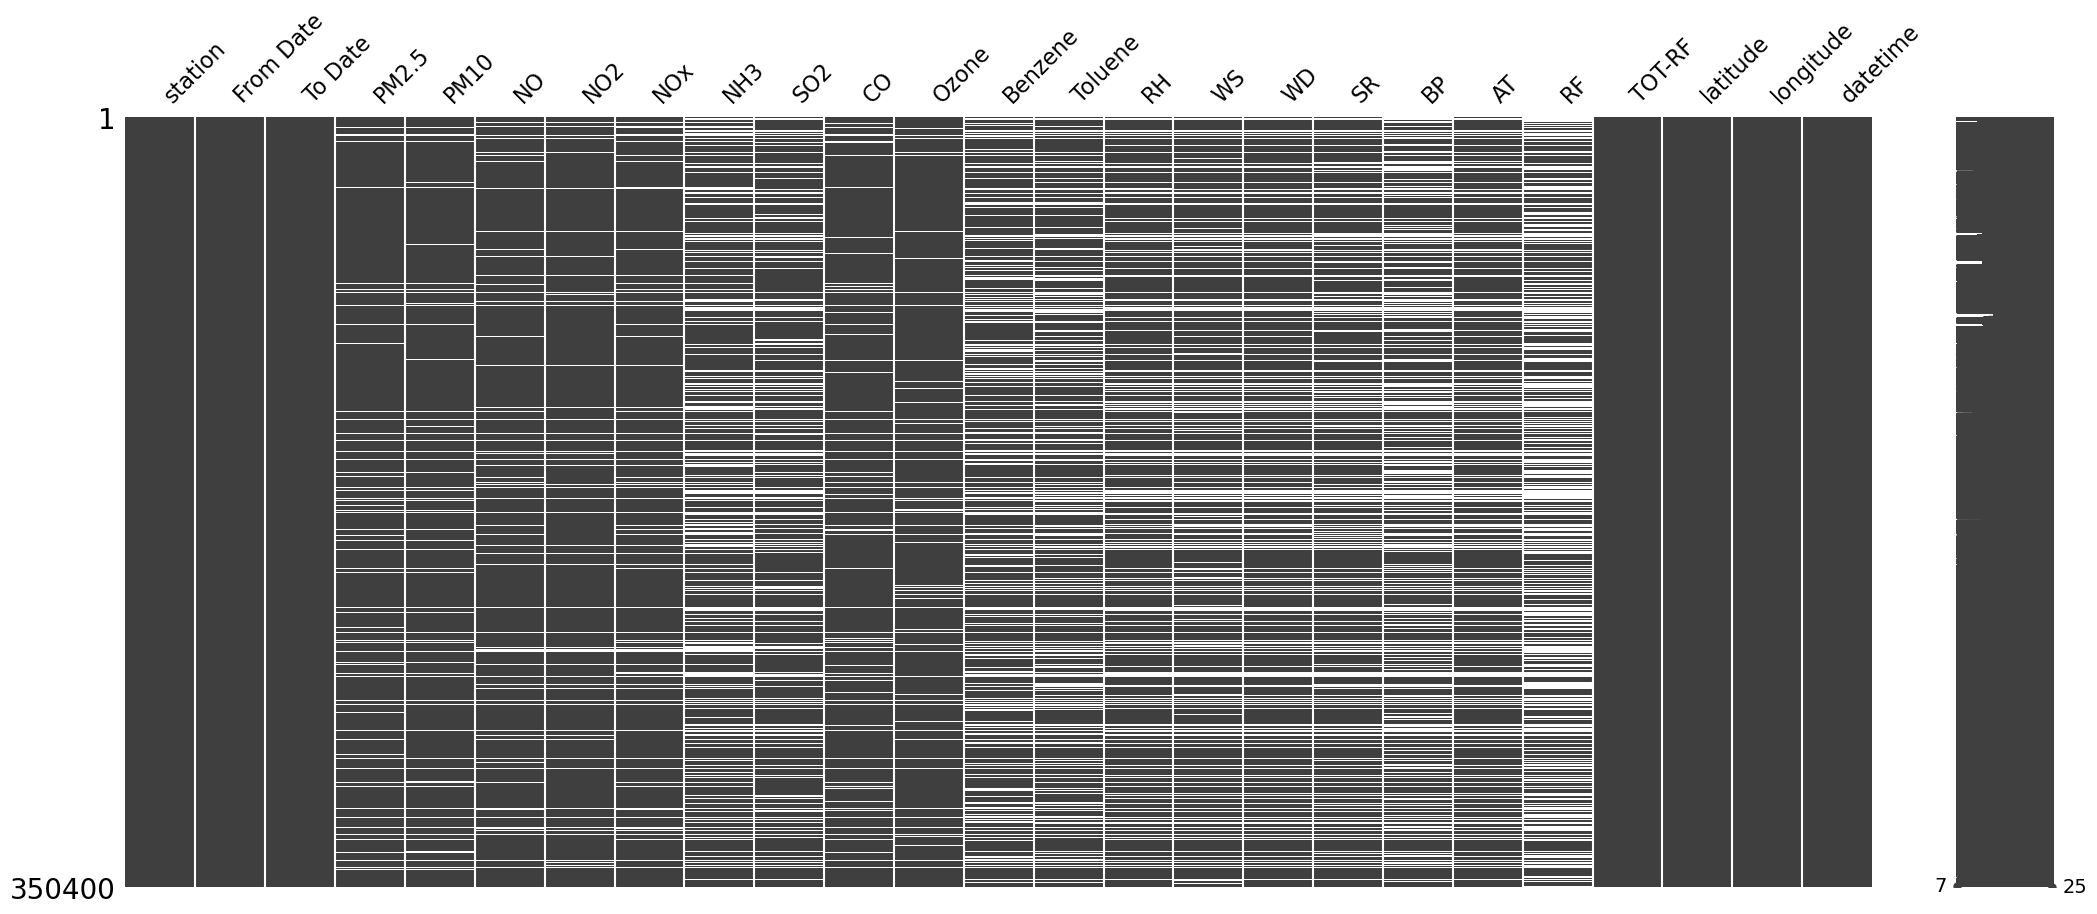

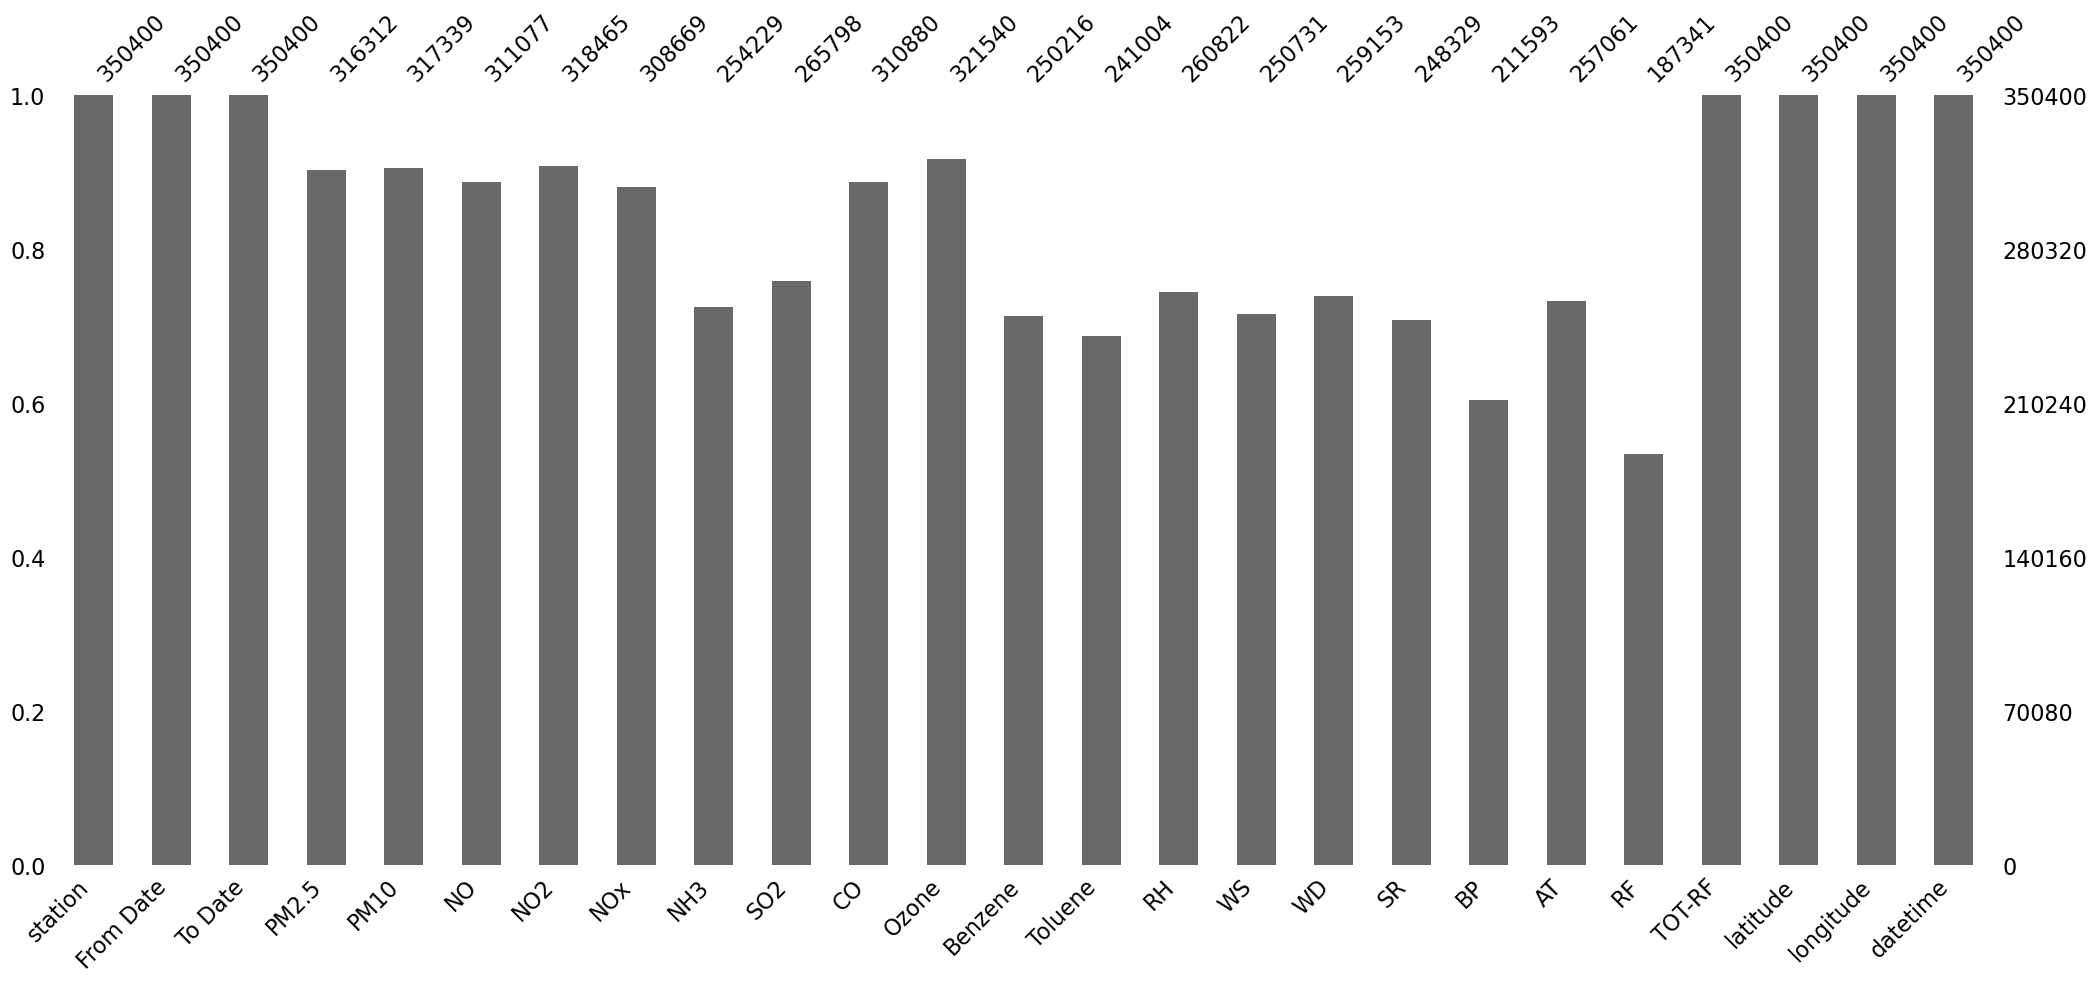

In [7]:
msno.matrix(df)  # Matrix plot
plt.show()

msno.bar(df)  # Bar plot
plt.show()

In [8]:
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [9]:
df.columns

Index(['station', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
       'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'relative_humidity',
       'wind_speed', 'wind_direction', 'solar_radiation', 'pressure',
       'temperature', 'rain_fall', 'total_rainfall', 'latitude', 'longitude',
       'datetime'],
      dtype='object')

In [10]:
df

,station,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,...,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude,datetime
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:30:00,"Alipur, Delhi - DPCC",2022-01-01 00:00:00,2022-01-01 01:00:00,219.5,342.75,94.73,53.95,105.95,3.78,2.02,...,NaN,205.95,4.60,999.10,6.85,0.0,0.0,28.815329,77.153010,2022-01-01 00:30:00
2022-01-01 00:30:00,"Wazirpur, Delhi - DPCC",2022-01-01 00:00:00,2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.699793,77.165453,2022-01-01 00:30:00
2022-01-01 00:30:00,"Najafgarh, Delhi - DPCC",2022-01-01 00:00:00,2022-01-01 01:00:00,140.0,179.00,68.27,16.60,84.85,45.20,2.92,...,0.73,249.88,3.18,998.98,5.53,0.0,0.0,28.570173,76.933762,2022-01-01 00:30:00
2022-01-01 00:30:00,"Narela, Delhi - DPCC",2022-01-01 00:00:00,2022-01-01 01:00:00,244.0,349.00,30.07,64.40,58.80,44.10,8.68,...,1.10,204.82,4.33,998.73,8.88,0.0,0.0,28.822836,77.101981,2022-01-01 00:30:00
2022-01-01 00:30:00,"Bawana, Delhi - DPCC",2022-01-01 00:00:00,2022-01-01 01:00:00,300.0,452.00,69.28,16.77,86.20,63.47,1.65,...,0.40,178.80,5.60,998.92,7.77,0.0,0.0,28.776200,77.051074,2022-01-01 00:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:30:00,"Sri Aurobindo Marg, Delhi - DPCC",2022-12-31 23:00:00,2023-01-01 00:00:00,154.5,182.00,34.30,31.42,44.67,34.73,8.15,...,0.83,157.95,8.53,986.65,9.12,0.0,0.0,28.531346,77.190156,2022-12-31 23:30:00
2022-12-31 23:30:00,"IHBAS, Dilshad Garden, Delhi - CPCB",2022-12-31 23:00:00,2023-01-01 00:00:00,96.4,202.80,78.62,16.24,71.40,38.77,10.63,...,1.97,297.80,14.77,NaN,12.70,NaN,0.0,28.681174,77.302523,2022-12-31 23:30:00
2022-12-31 23:30:00,"Major Dhyan Chand National Stadium, Delhi - DPCC",2022-12-31 23:00:00,2023-01-01 00:00:00,207.0,253.00,117.90,29.70,147.78,73.30,6.78,...,0.53,248.68,4.60,997.17,12.12,0.0,0.0,28.611281,77.237738,2022-12-31 23:30:00


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['station'] = le.fit_transform(df['station'])

In [12]:
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'relative_humidity', 'wind_speed', 'wind_direction', 'solar_radiation', 'pressure', 'temperature', 'rain_fall', 'total_rainfall']

values = {}
for var in cols:    
    temp = []
    for station in np.sort(df.station.unique()):
        tmp_df = df[df.station==station]
#         print(station, ': ', tmp_df[var].dropna().shape[0]/tmp_df[var].shape[0])
        temp.append([tmp_df[var].dropna().shape[0]/tmp_df[var].shape[0], station])
#         print("values:", values)
    values[var] = temp
#     plt.figure(figsize=(20,5));
#     plt.plot([i[1] for i in values], [i[0] for i in values])
#     plt.title(var);
#     plt.ylabel('fraction of available data')
#     plt.xlabel('station id')
#     plt.xticks(df.station)
#     plt.grid(True)

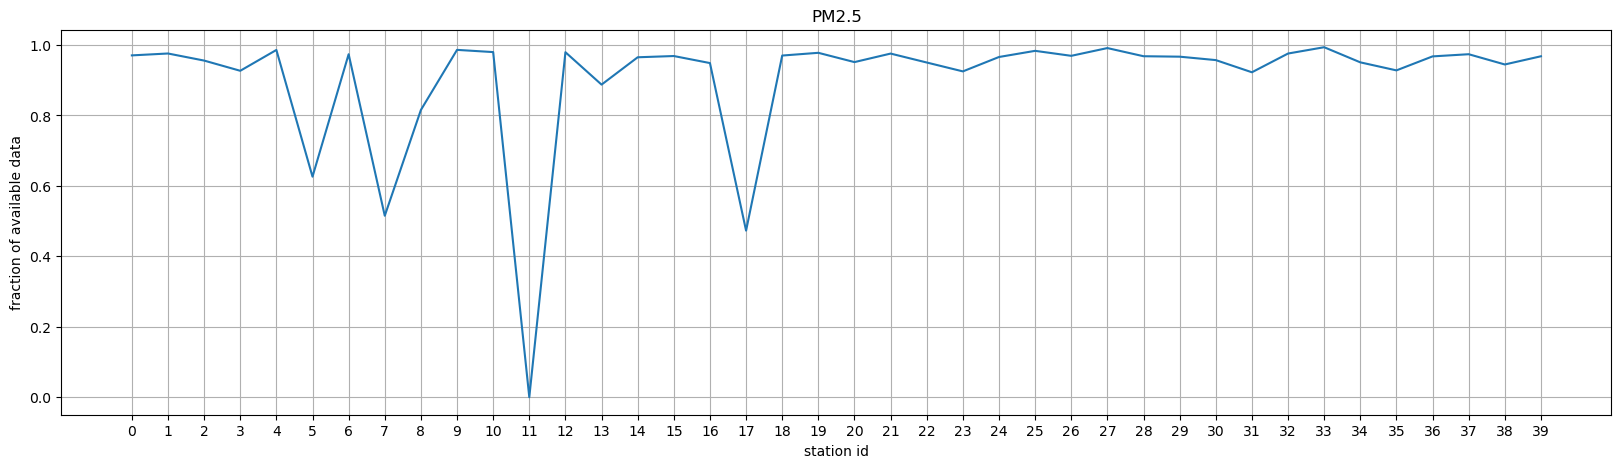

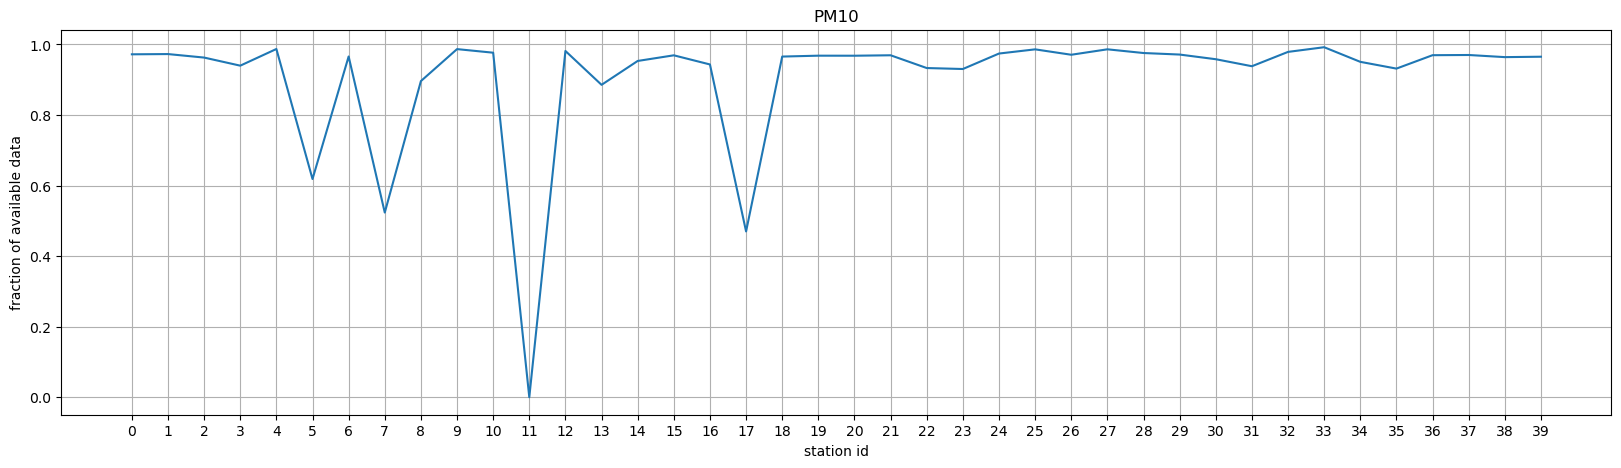

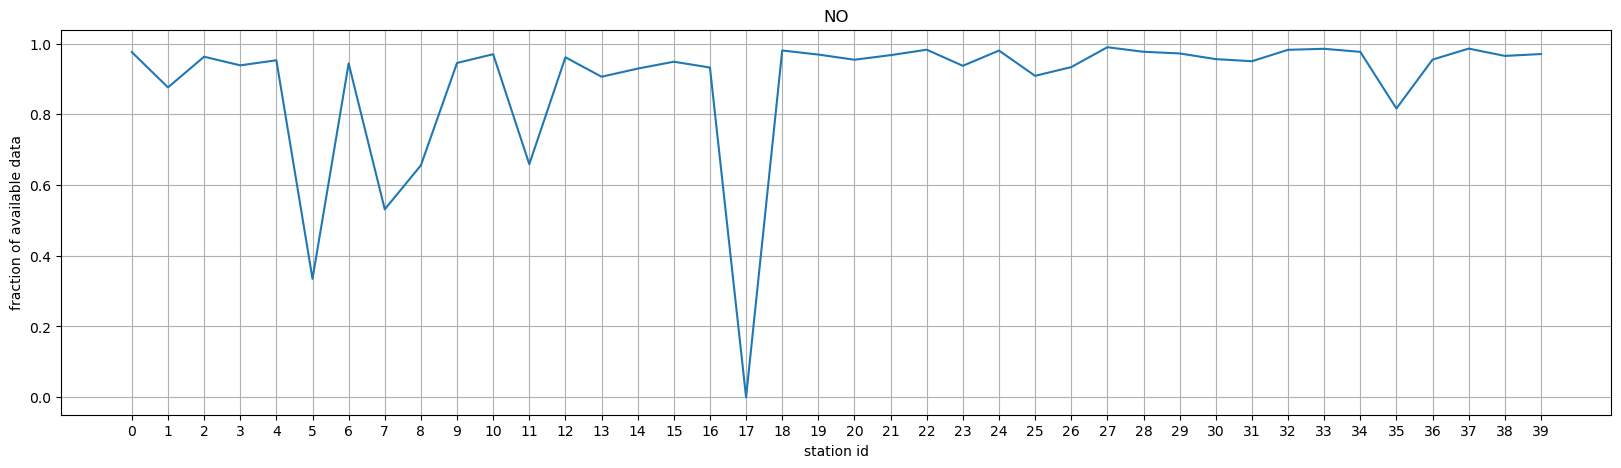

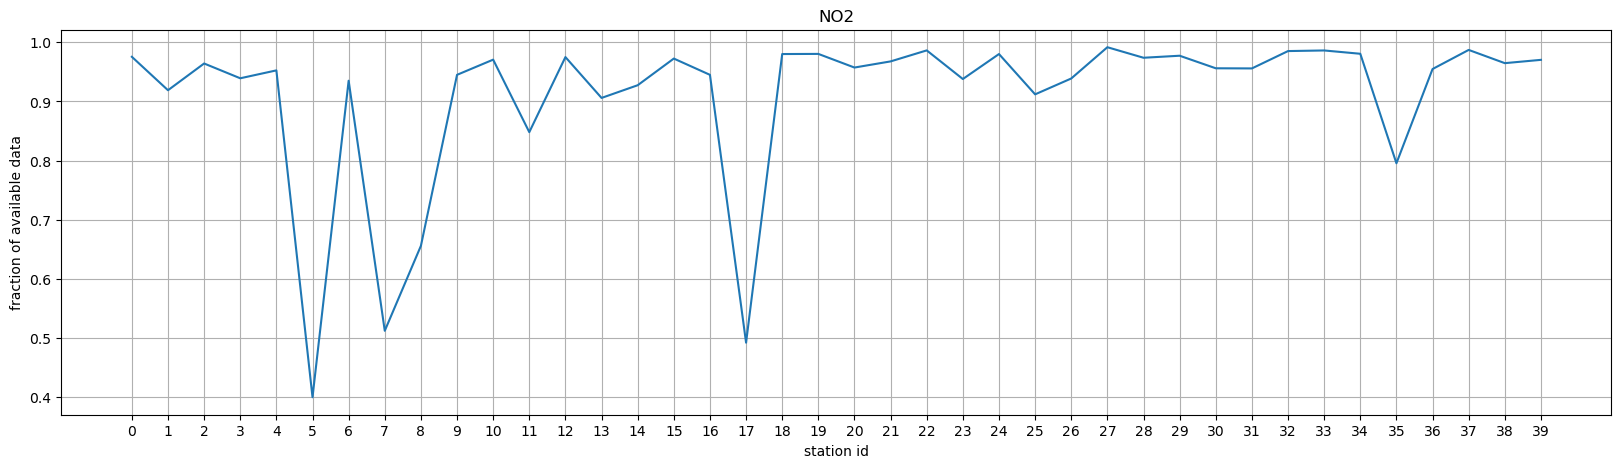

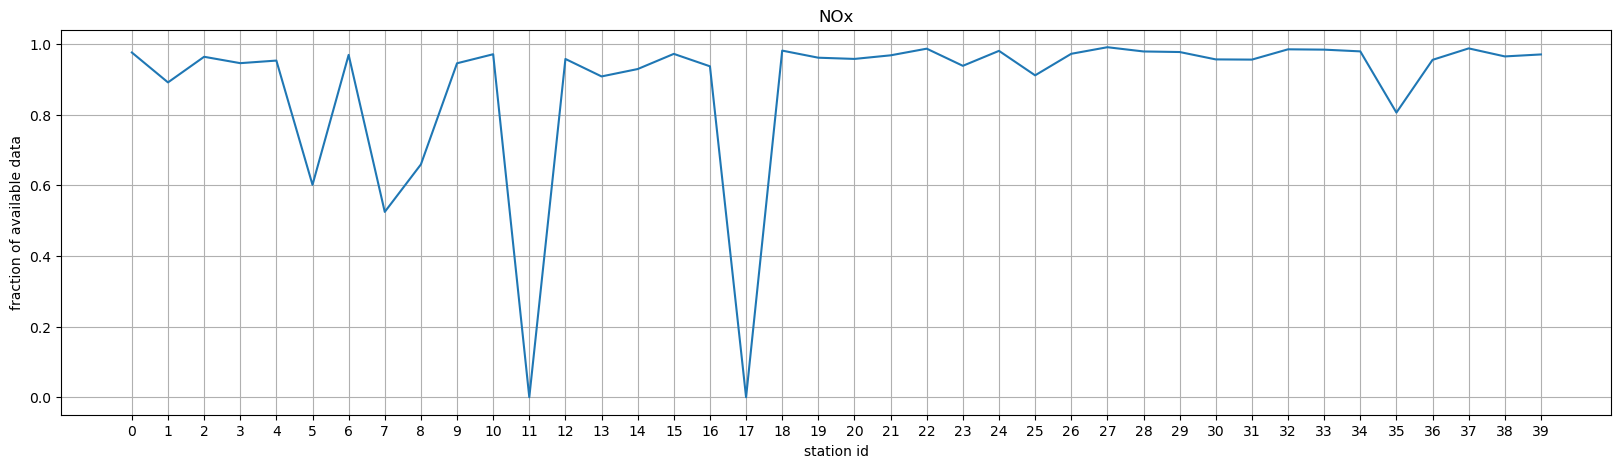

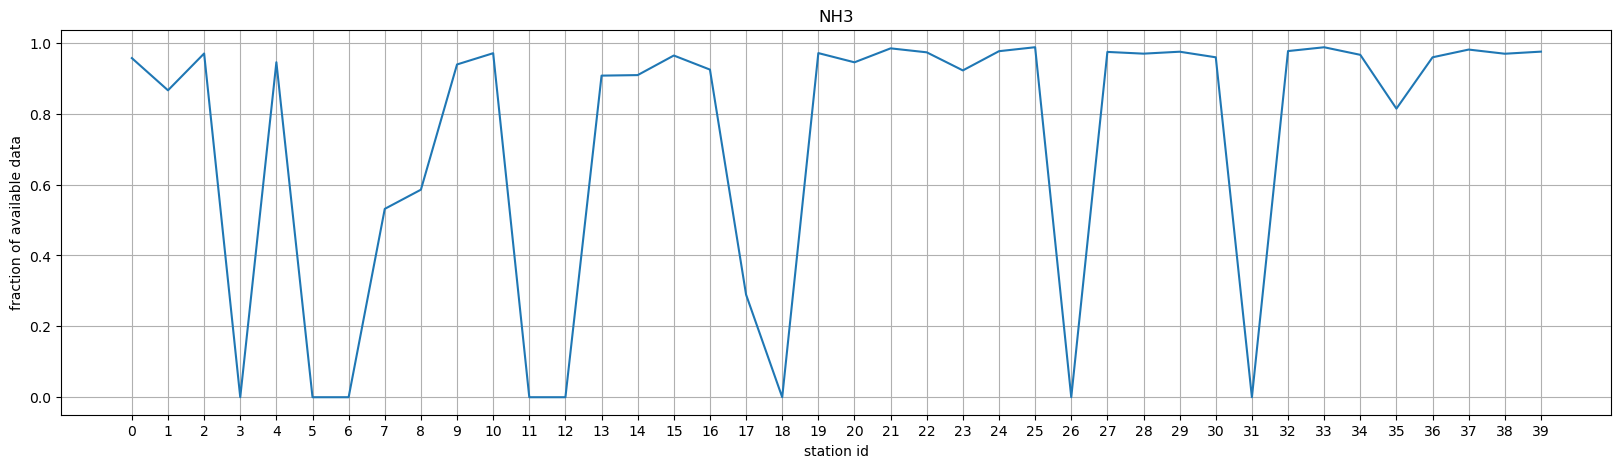

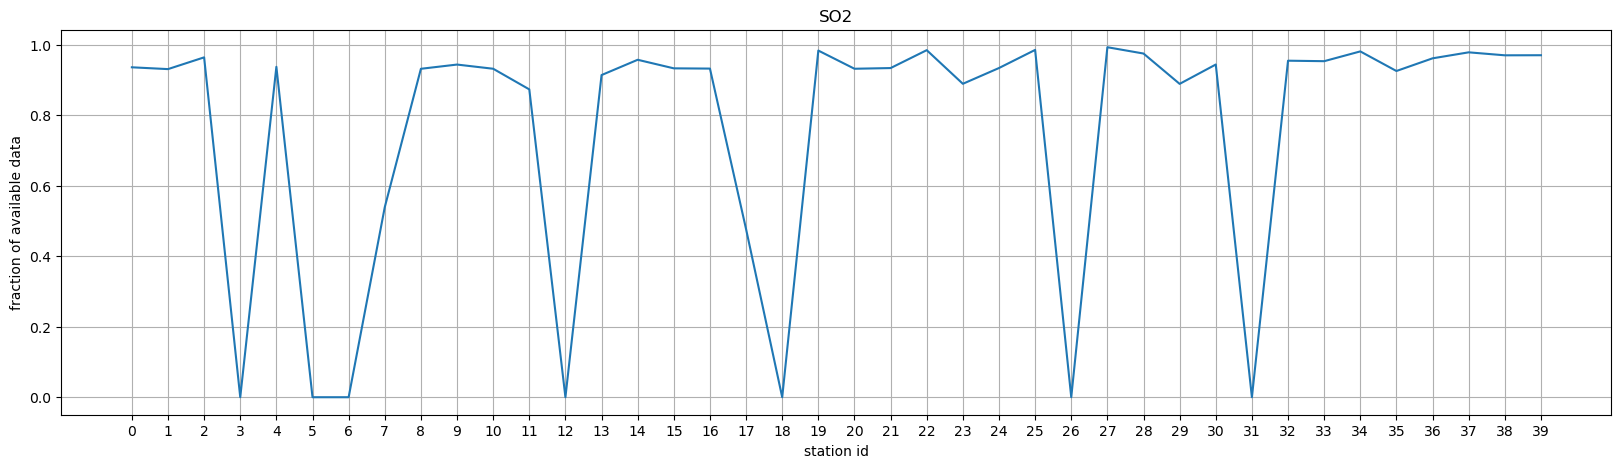

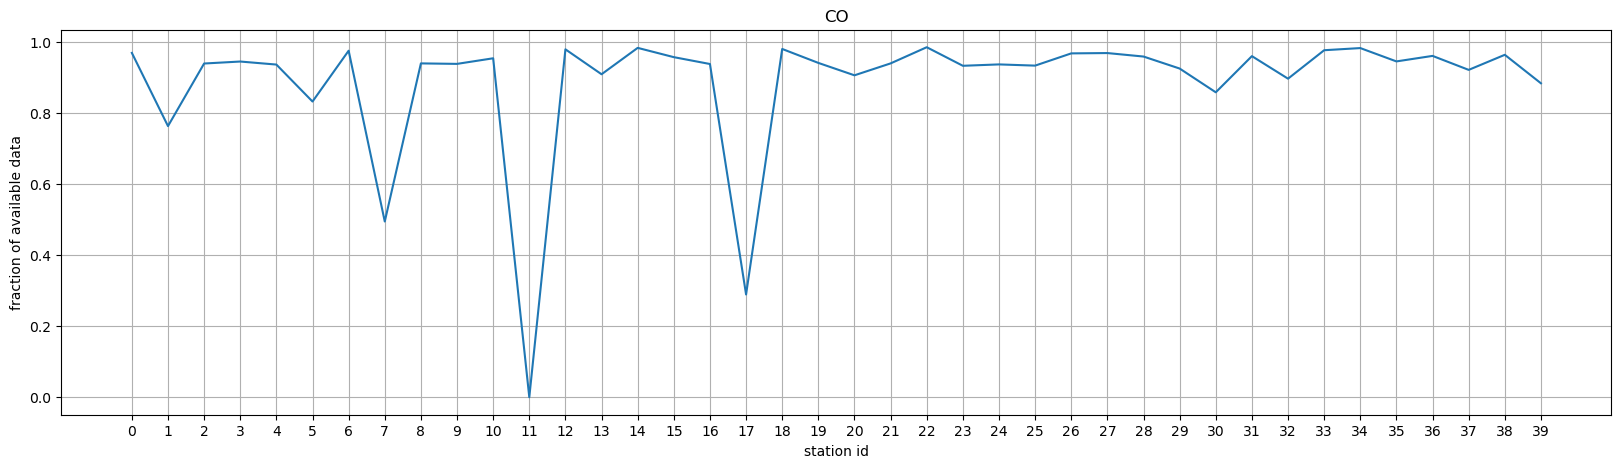

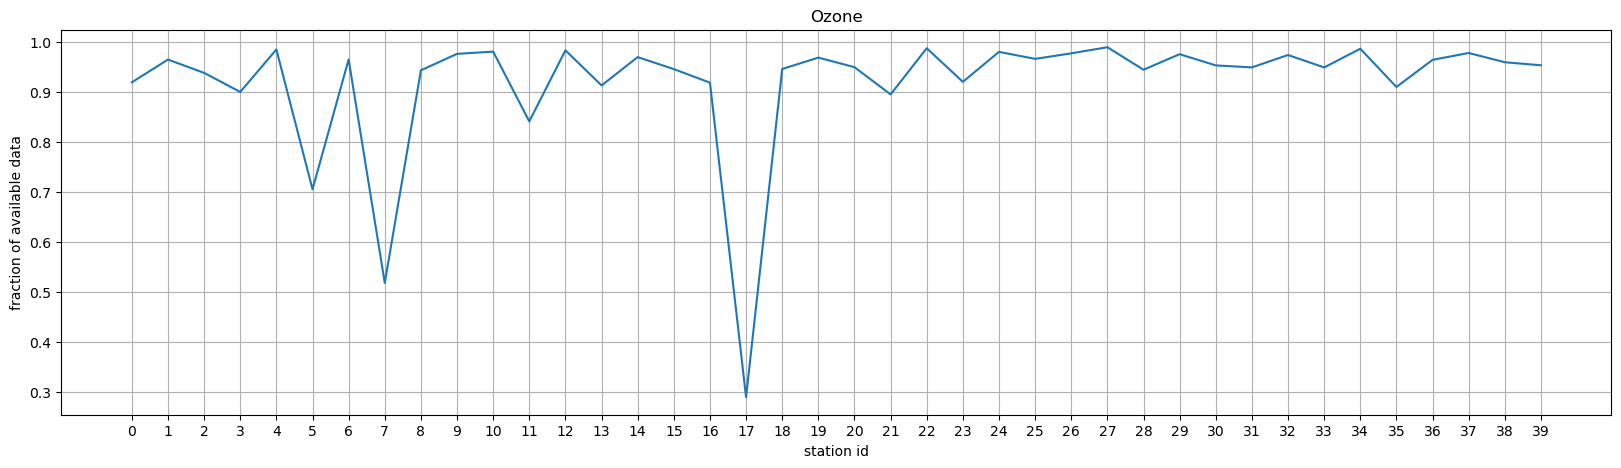

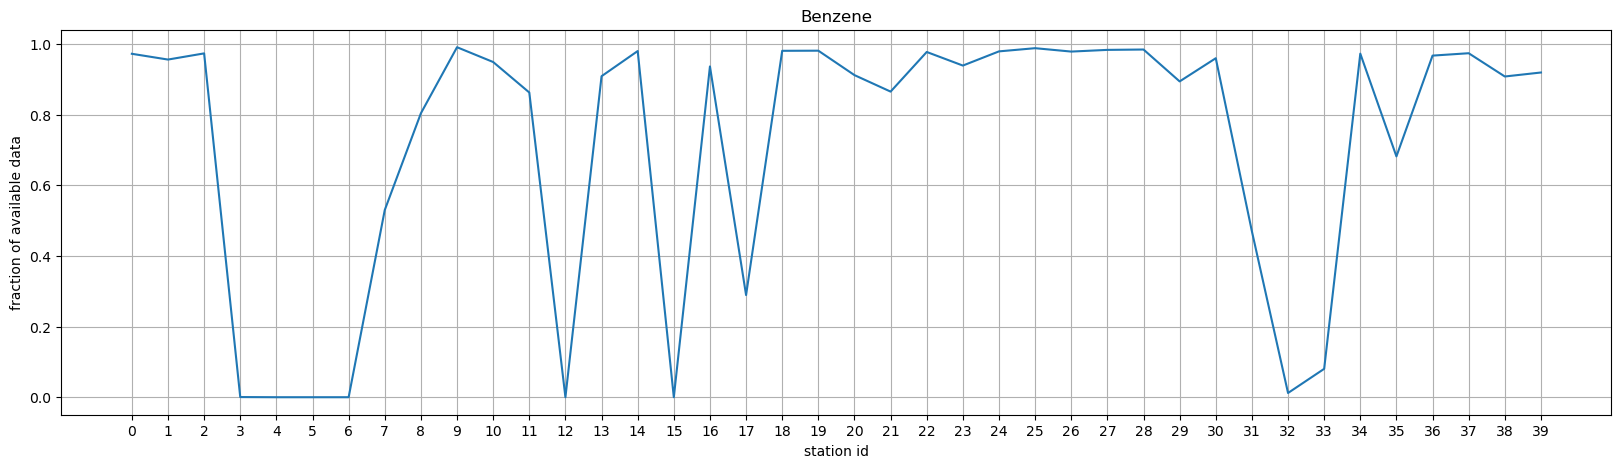

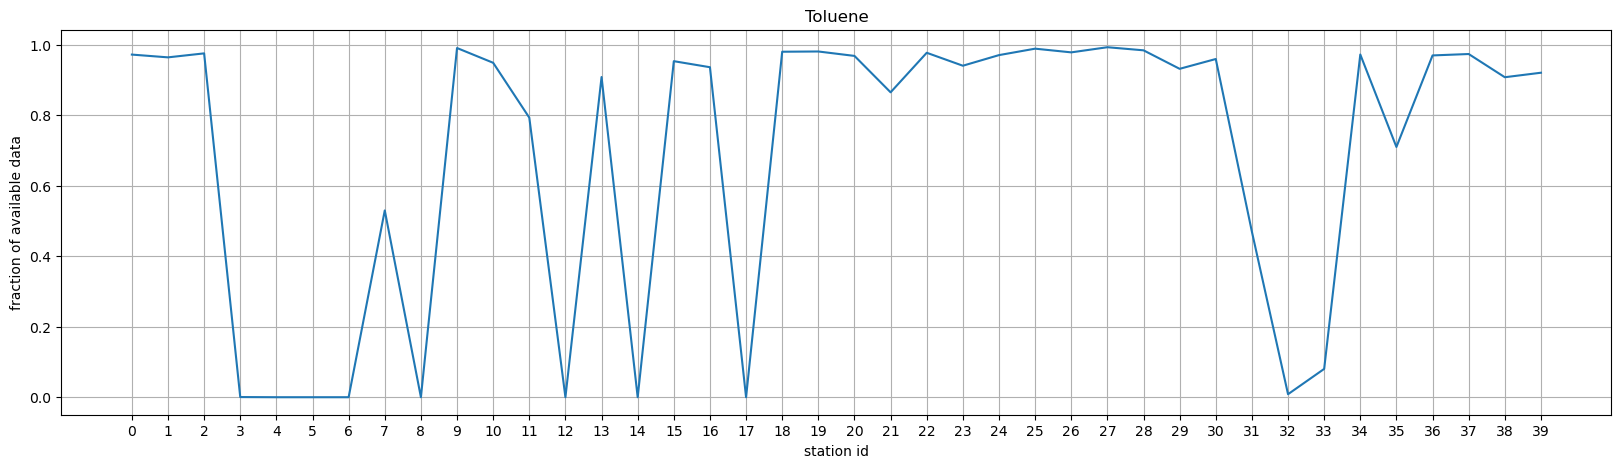

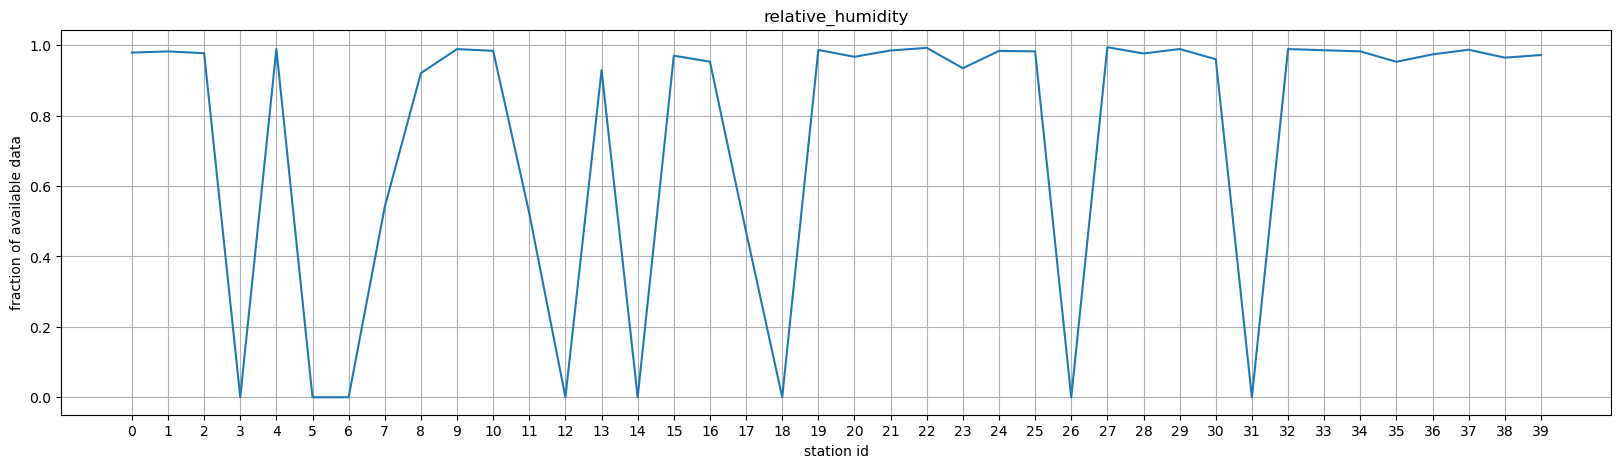

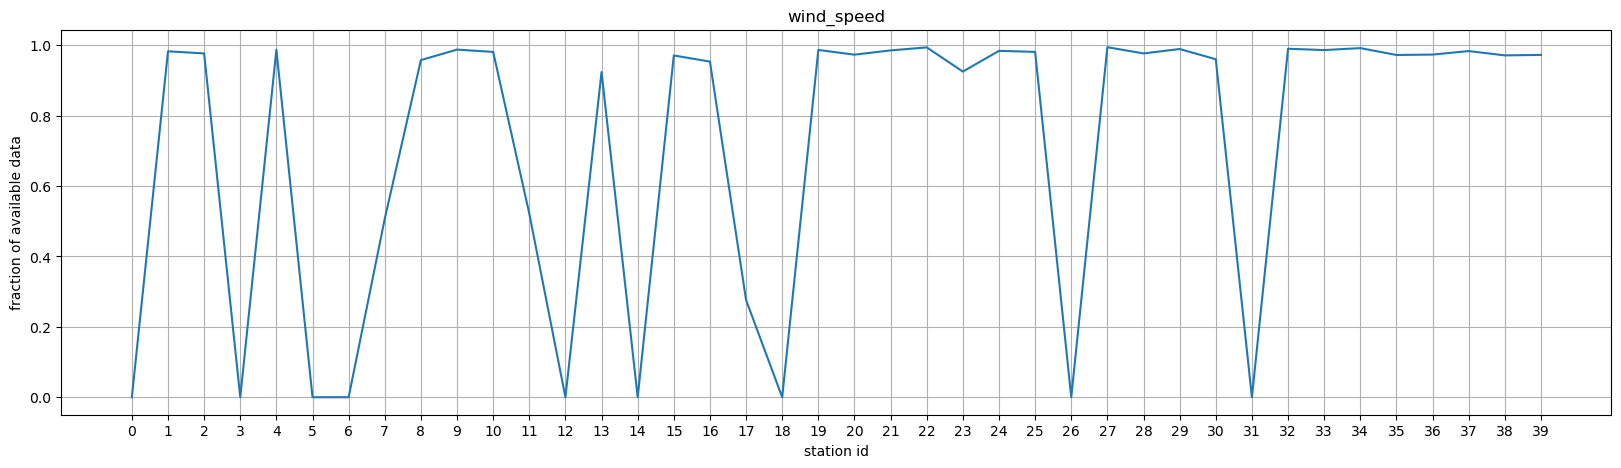

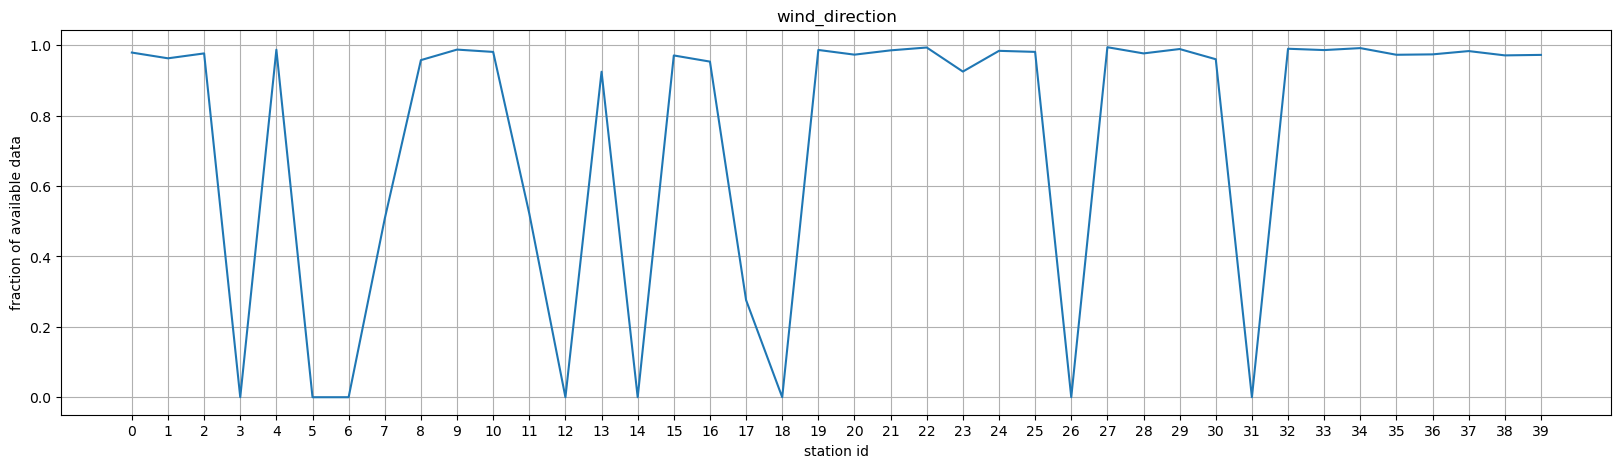

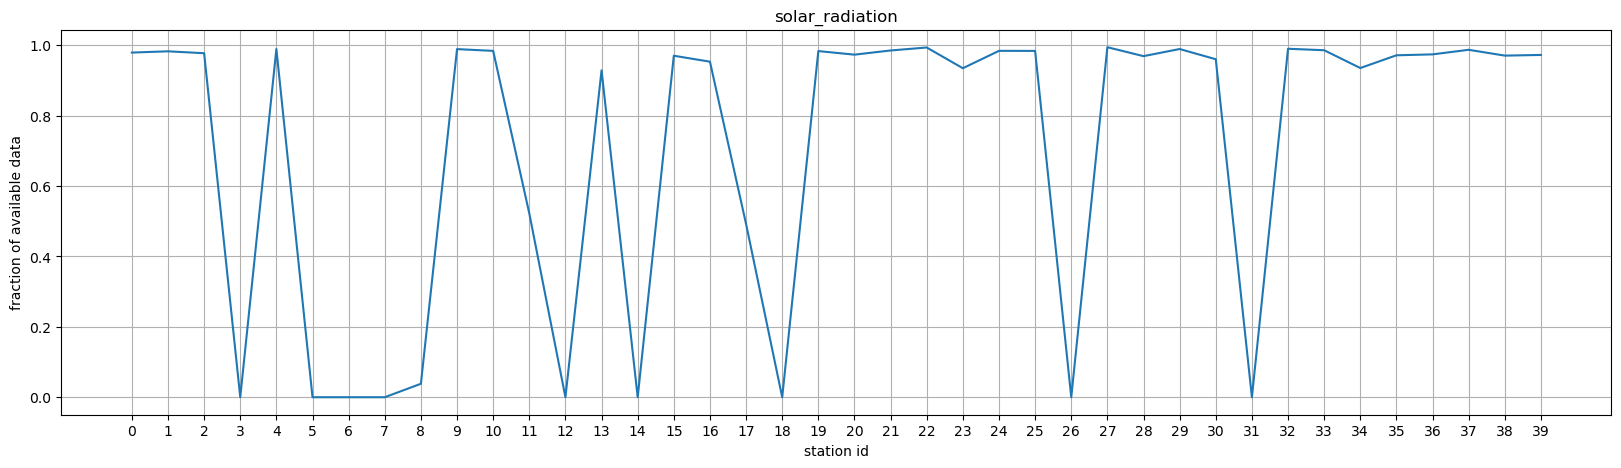

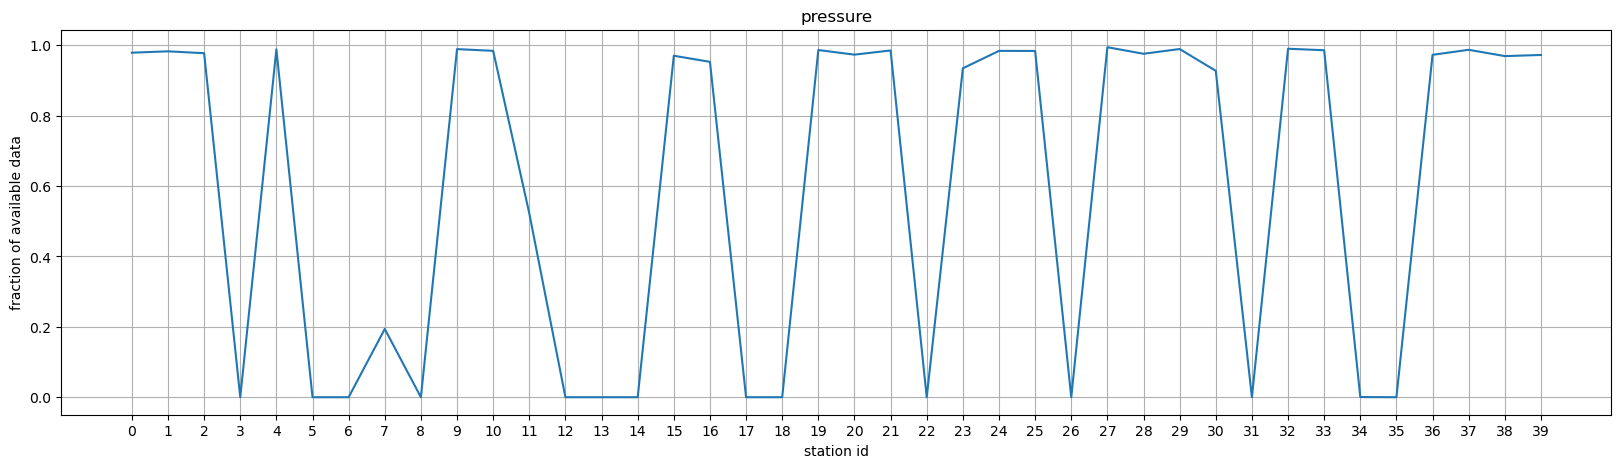

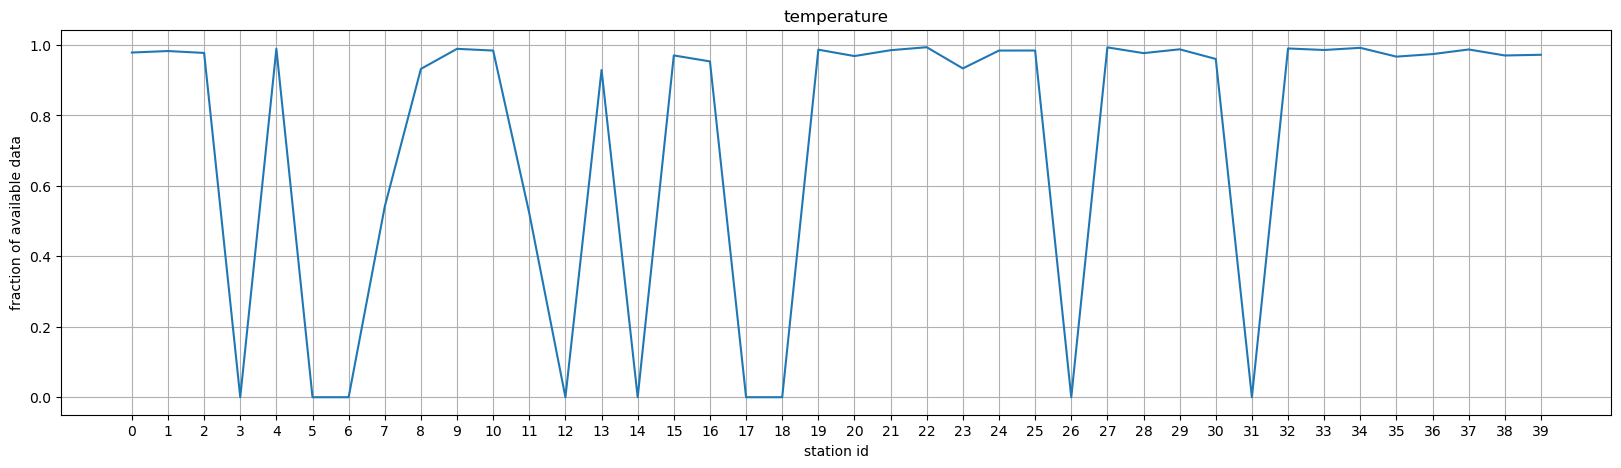

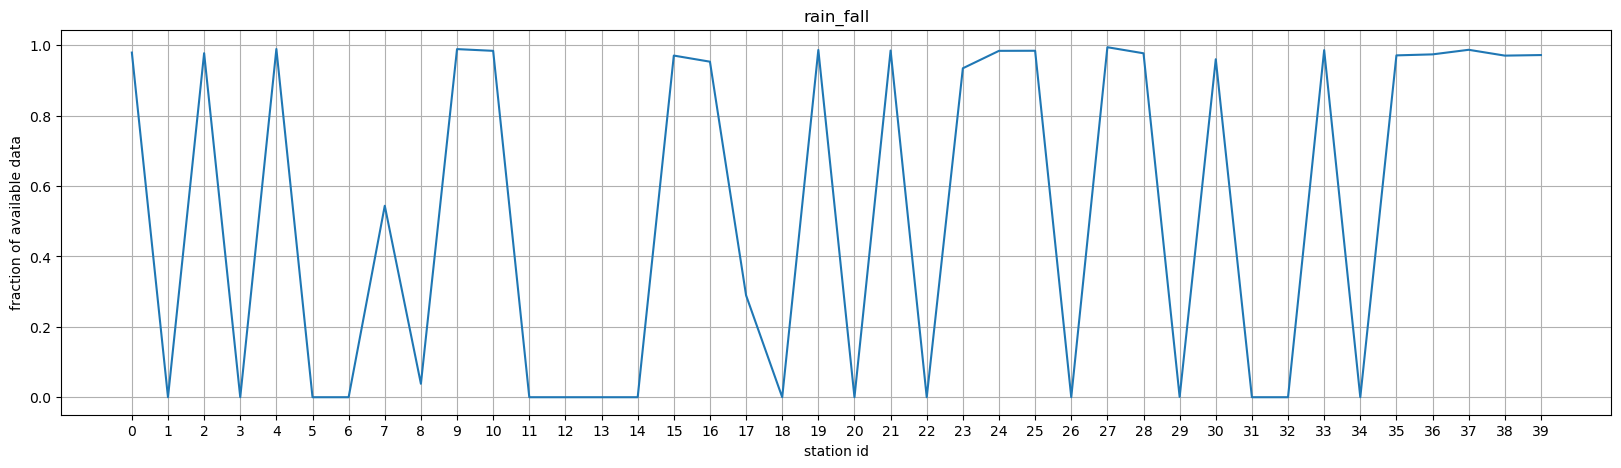

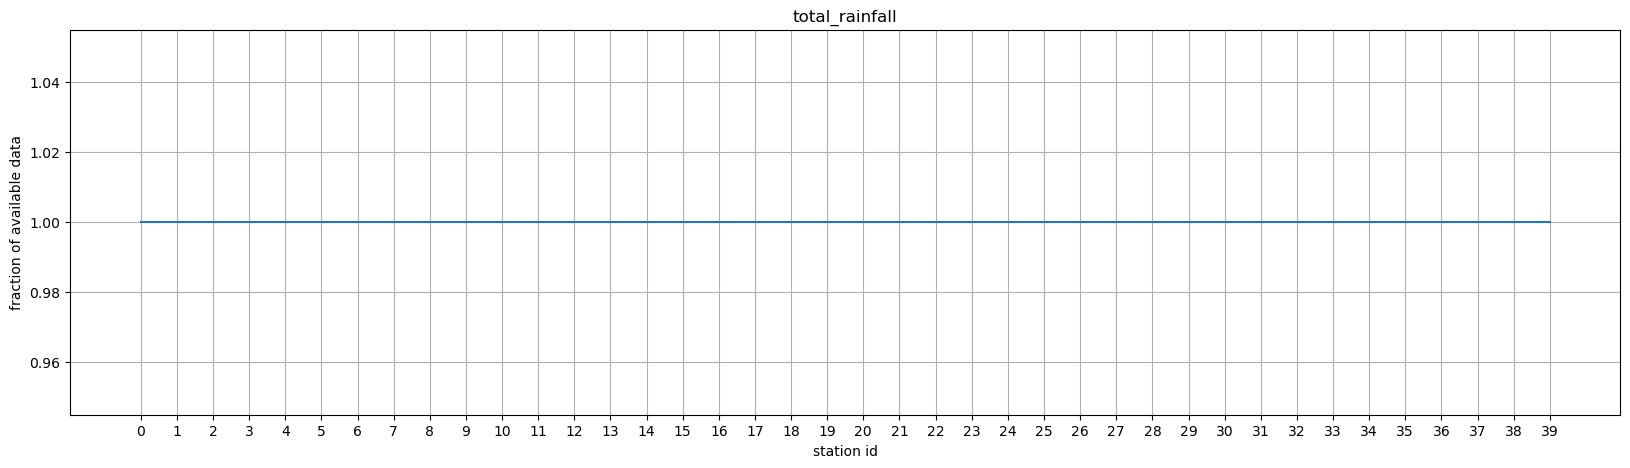

In [13]:
for i in values.keys():
    plt.figure(figsize=(20,5));
    plt.plot([j[1] for j in values[i]], [j[0] for j in values[i]])
    plt.title(i)
    plt.ylabel('fraction of available data')
    plt.xlabel('station id')
    plt.xticks([j for j in np.sort(df.station.unique())])
    plt.grid(True)
    plt.show()

In [14]:
integer_mapping = {l: i for i, l in enumerate(le.classes_)}
integer_mapping

{'Alipur, Delhi - DPCC': 0,
 'Anand Vihar, Delhi - DPCC': 1,
 'Ashok Vihar, Delhi - DPCC': 2,
 'Aya Nagar, Delhi - IMD': 3,
 'Bawana, Delhi - DPCC': 4,
 'Burari Crossing, Delhi - IMD': 5,
 'CRRI Mathura Road, Delhi - IMD': 6,
 'Chandni Chowk, Delhi - IITM': 7,
 'DTU, Delhi - CPCB': 8,
 'Dr. Karni Singh Shooting Range, Delhi - DPCC': 9,
 'Dwarka-Sector 8, Delhi - DPCC ': 10,
 'East Arjun Nagar, Delhi - CPCB': 11,
 'IGI Airport (T3), Delhi - IMD': 12,
 'IHBAS, Dilshad Garden, Delhi - CPCB': 13,
 'ITO, Delhi - CPCB': 14,
 'Jahangirpuri, Delhi - DPCC': 15,
 'Jawaharlal Nehru Stadium, Delhi - DPCC': 16,
 'Lodhi Road, Delhi - IITM': 17,
 'Lodhi Road, Delhi - IMD': 18,
 'Major Dhyan Chand National Stadium, Delhi - DPCC': 19,
 'Mandir Marg, Delhi - DPCC': 20,
 'Mundka, Delhi - DPCC': 21,
 'NSIT Dwarka, Delhi - CPCB': 22,
 'Najafgarh, Delhi - DPCC': 23,
 'Narela, Delhi - DPCC': 24,
 'Nehru Nagar, Delhi - DPCC': 25,
 'North Campus, DU, Delhi - IMD': 26,
 'Okhla Phase-2, Delhi - DPCC': 27,
 'Patp

In [15]:
station_wise_df = []
methods = {'PM2.5': 'linear', 
                'PM10': 'linear',
                'NO': 'linear', 
                'NO2': 'linear',
                'NOx': 'linear',
                'NH3': 'linear',
                'SO2': 'linear',
                'CO': 'linear',
                'Ozone': 'linear',
                'Benzene': 'linear',
                'Toluene': 'linear',
                'relative_humidity': 'linear',
                'wind_speed': 'linear',
                'wind_direction': 'linear',
                'solar_radiation': 'linear',
                'pressure': 'linear',
                'temperature': 'linear',
                'rain_fall': 'linear'}
for station in df.station.unique():
    tmp_df = df[df.station == station]
    tmp_df['filled'] = True
    for var, method in methods.items():
        if var == 'PM25_Concentration':
            tmp_df.loc[tmp_df.dropna(subset=[var]).index, 'filled'] = False
        tmp_df[var] = tmp_df[var].interpolate(method).ffill().bfill()
    station_wise_df.append(tmp_df)
    
filled_df = pd.concat(station_wise_df)
filled_df.isna().sum()

station                   0
From Date                 0
To Date                   0
PM2.5                  8760
PM10                   8760
NO                     8760
NO2                       0
NOx                   17520
NH3                   70080
SO2                   61320
CO                     8760
Ozone                     0
Benzene               43800
Toluene               61320
relative_humidity     70080
wind_speed            78840
wind_direction        70080
solar_radiation       78840
pressure             113880
temperature           78840
rain_fall            131400
total_rainfall            0
latitude                  0
longitude                 0
datetime                  0
filled                    0
dtype: int64

In [16]:
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'relative_humidity', 'wind_speed', 'wind_direction', 'solar_radiation', 'pressure', 'temperature', 'rain_fall', 'total_rainfall']

values = {}
for var in cols:    
    temp = []
    for station in np.sort(filled_df.station.unique()):
        tmp_df = filled_df[filled_df.station==station]
#         print(station, ': ', tmp_df[var].dropna().shape[0]/tmp_df[var].shape[0])
        temp.append([tmp_df[var].dropna().shape[0]/tmp_df[var].shape[0], station])
#         print("values:", values)
    values[var] = temp

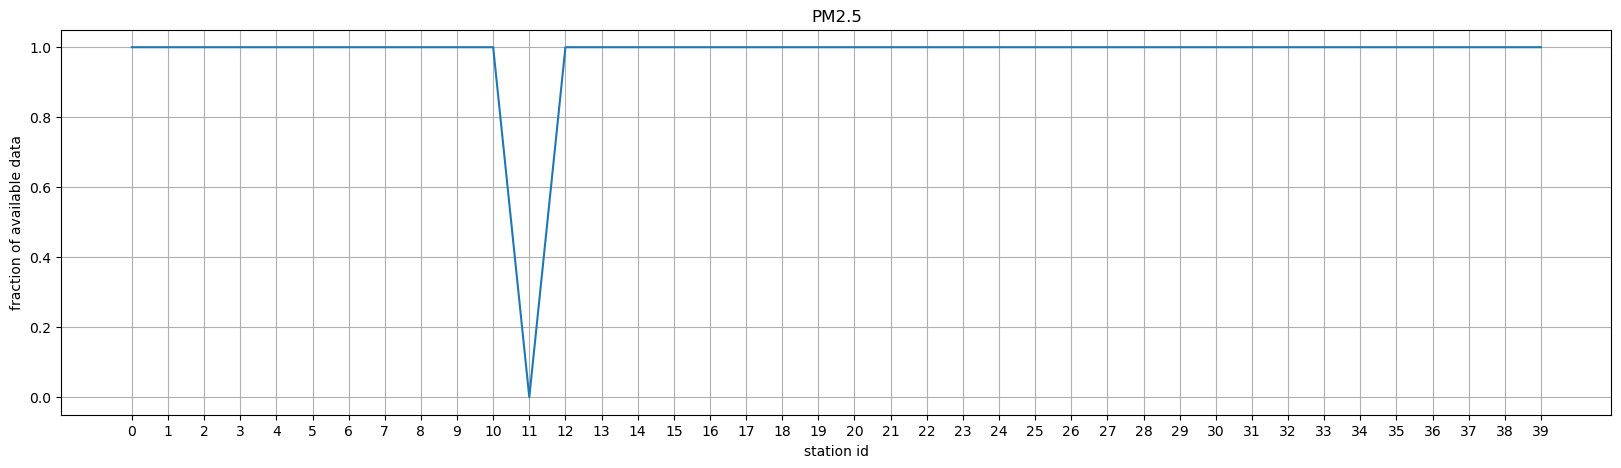

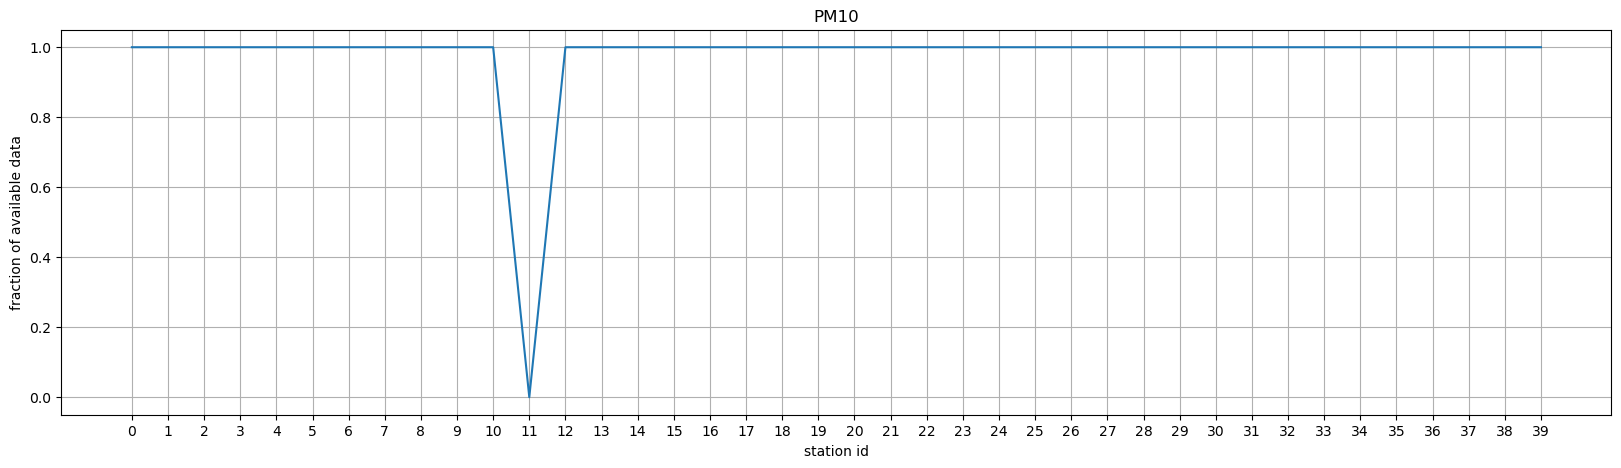

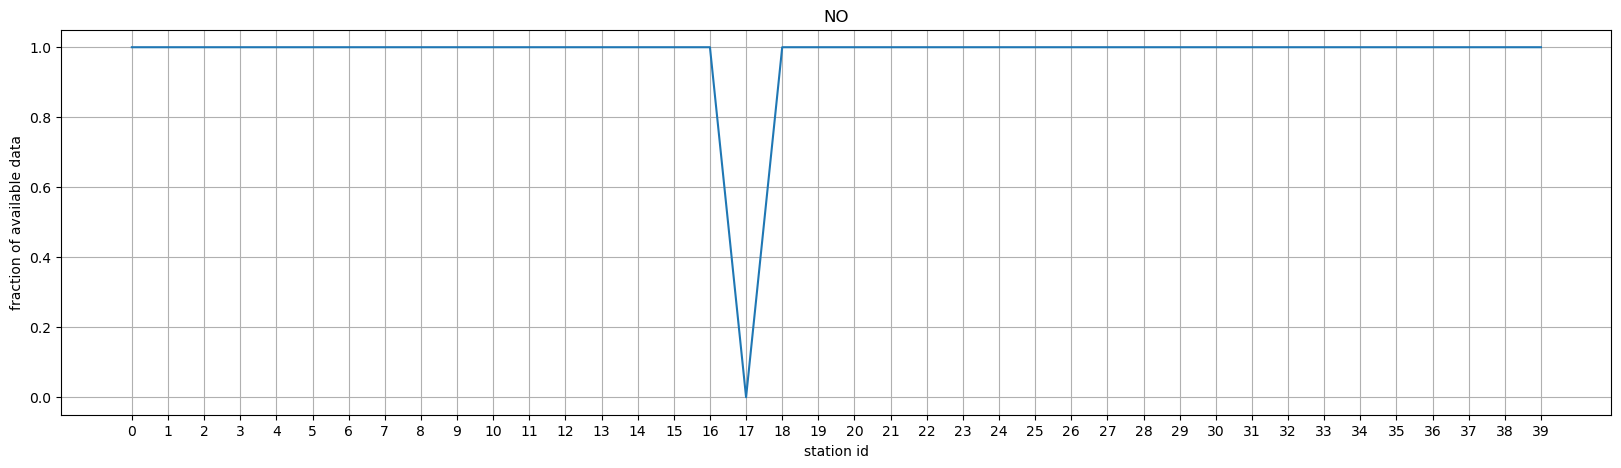

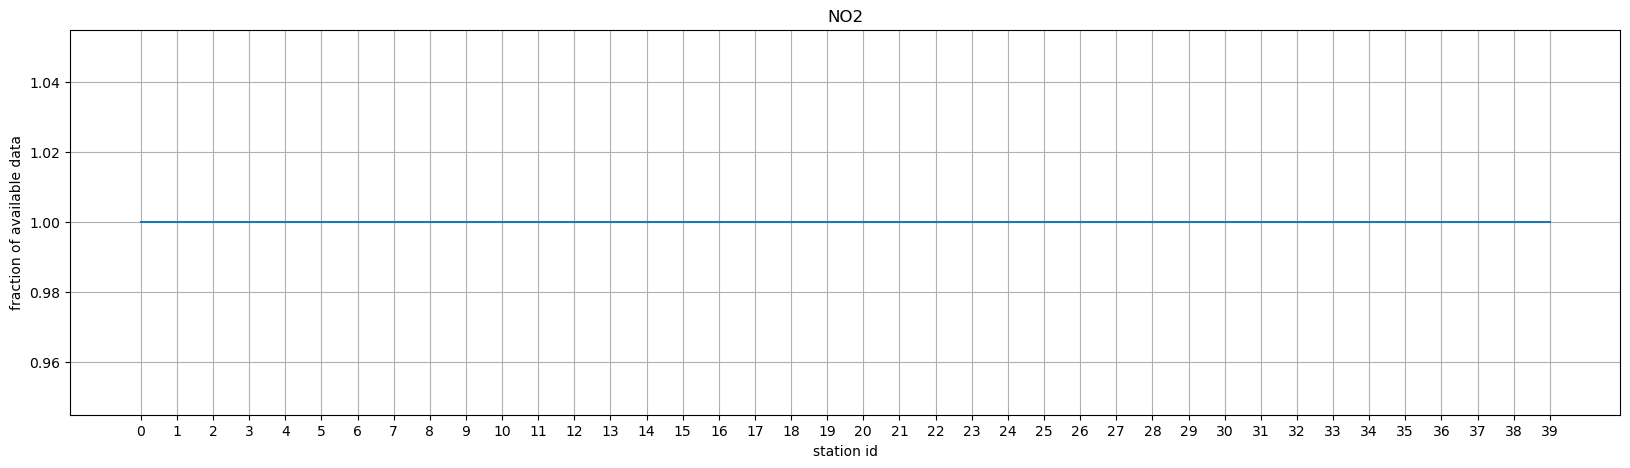

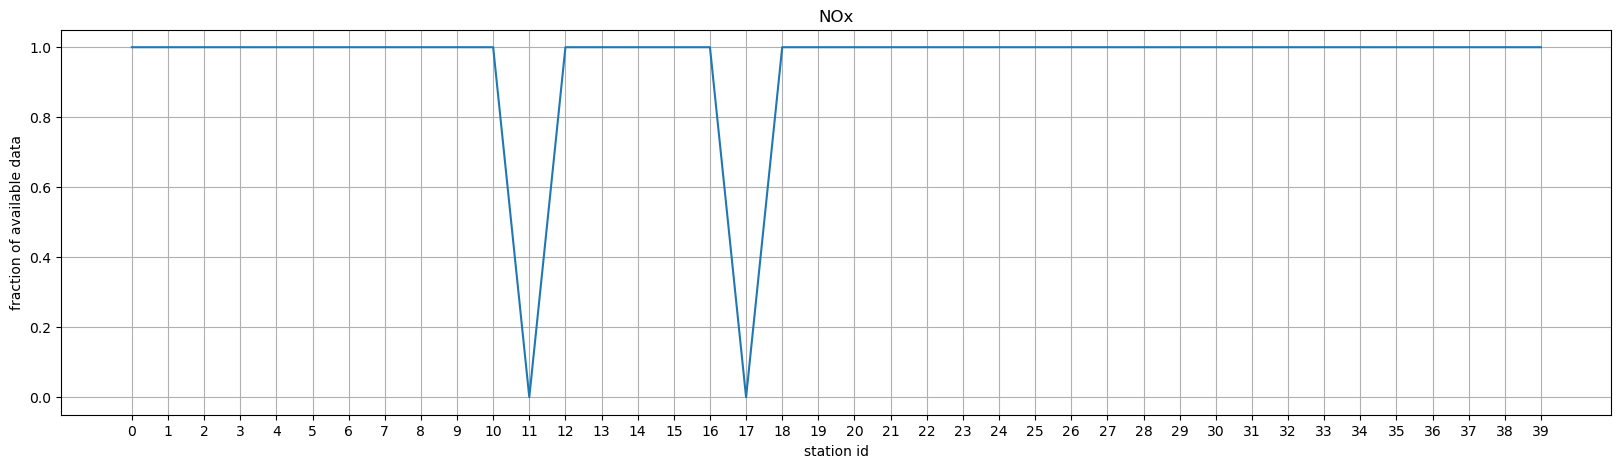

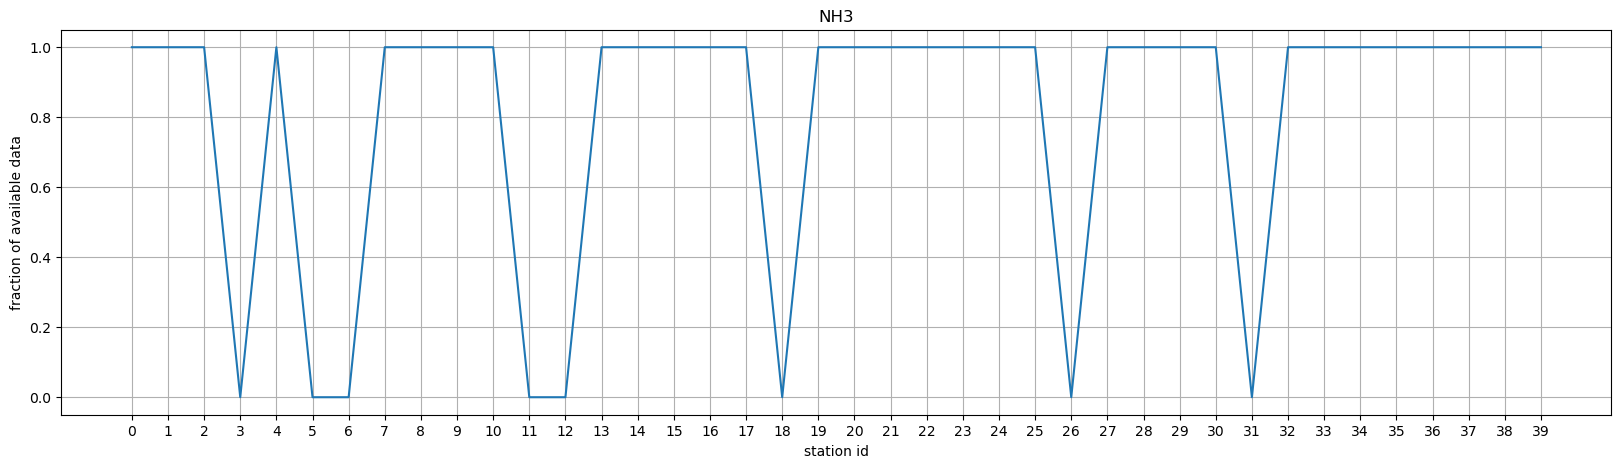

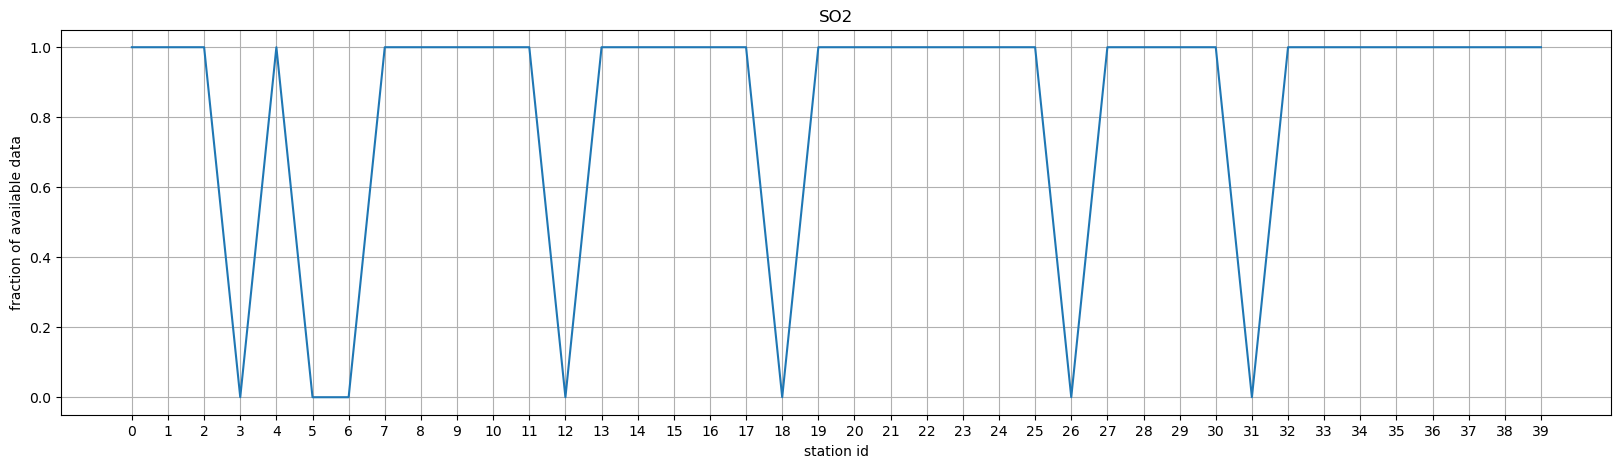

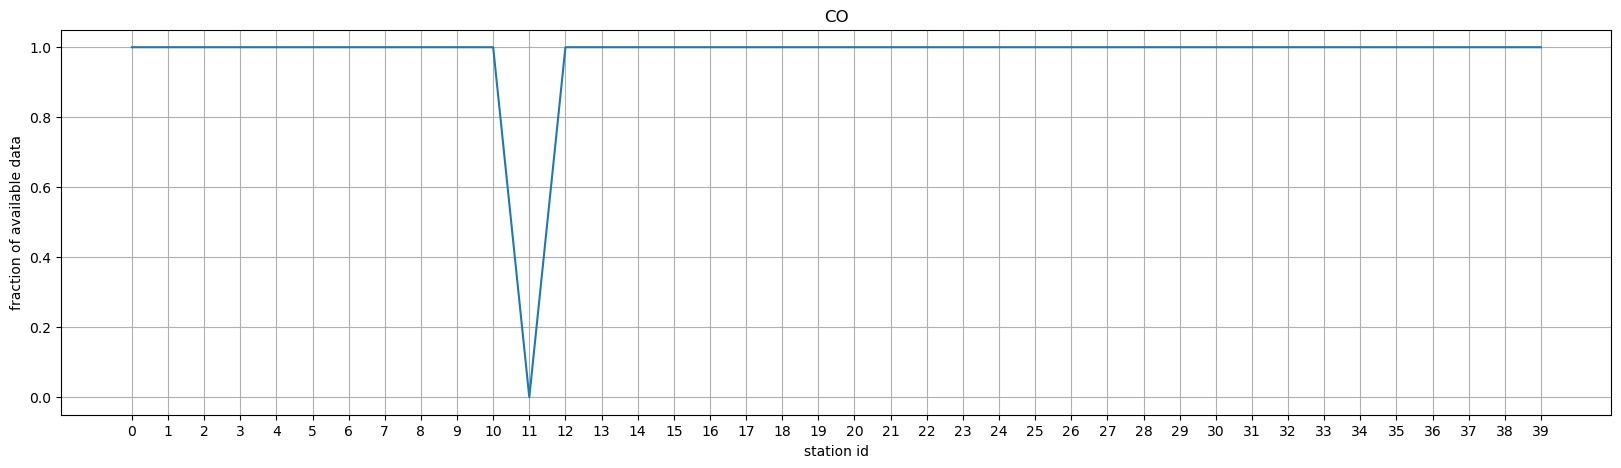

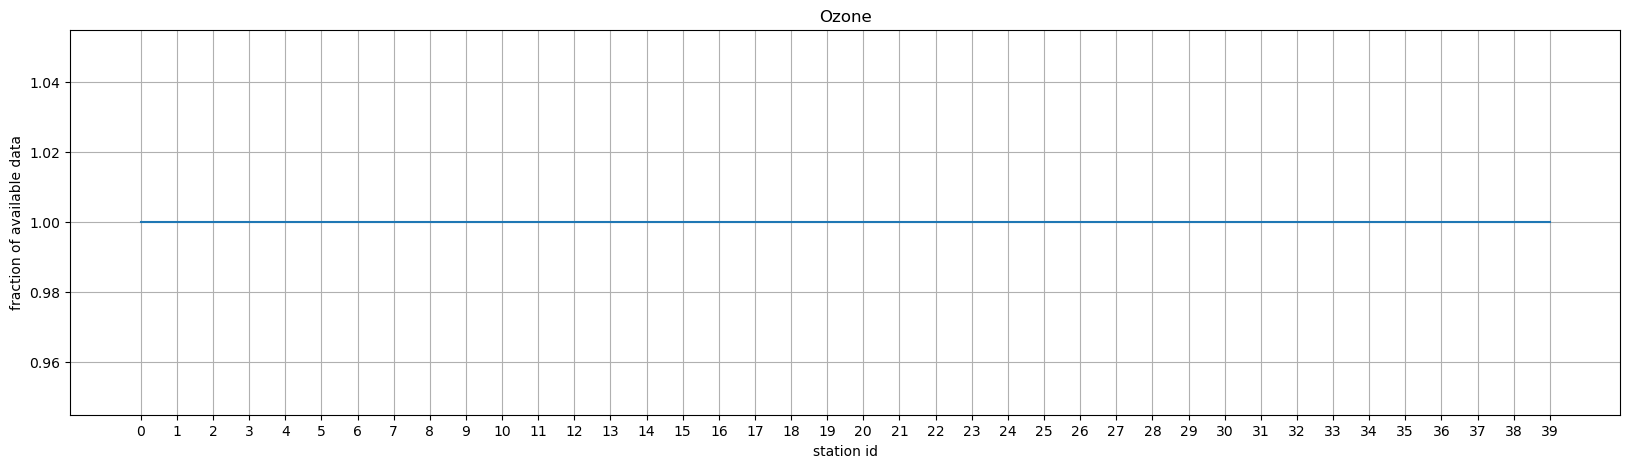

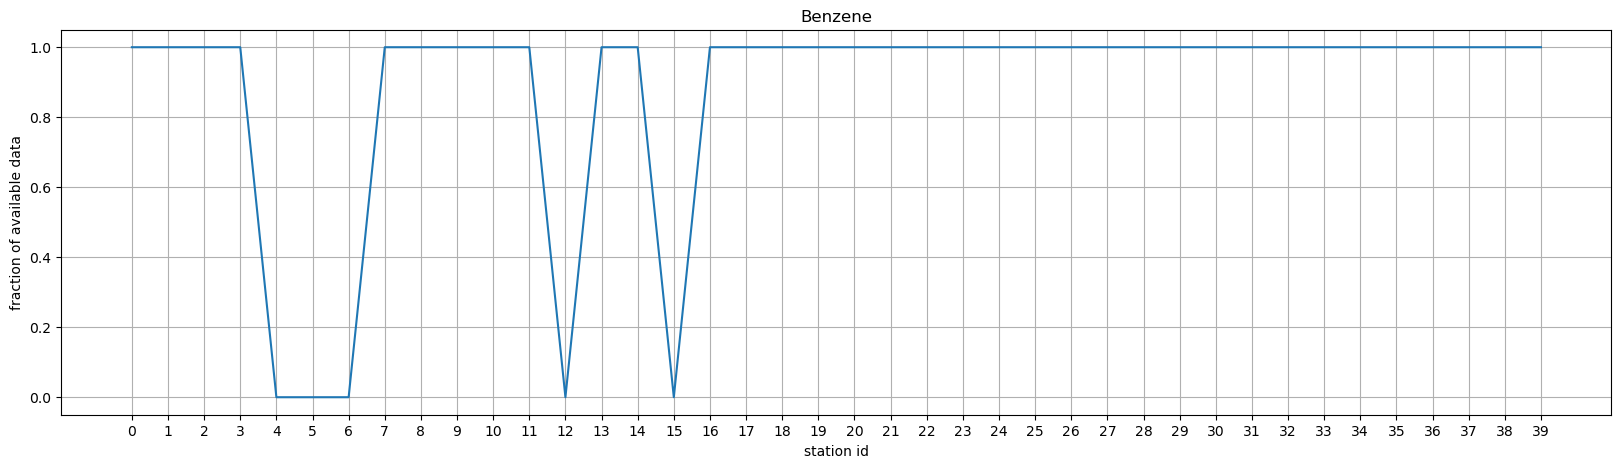

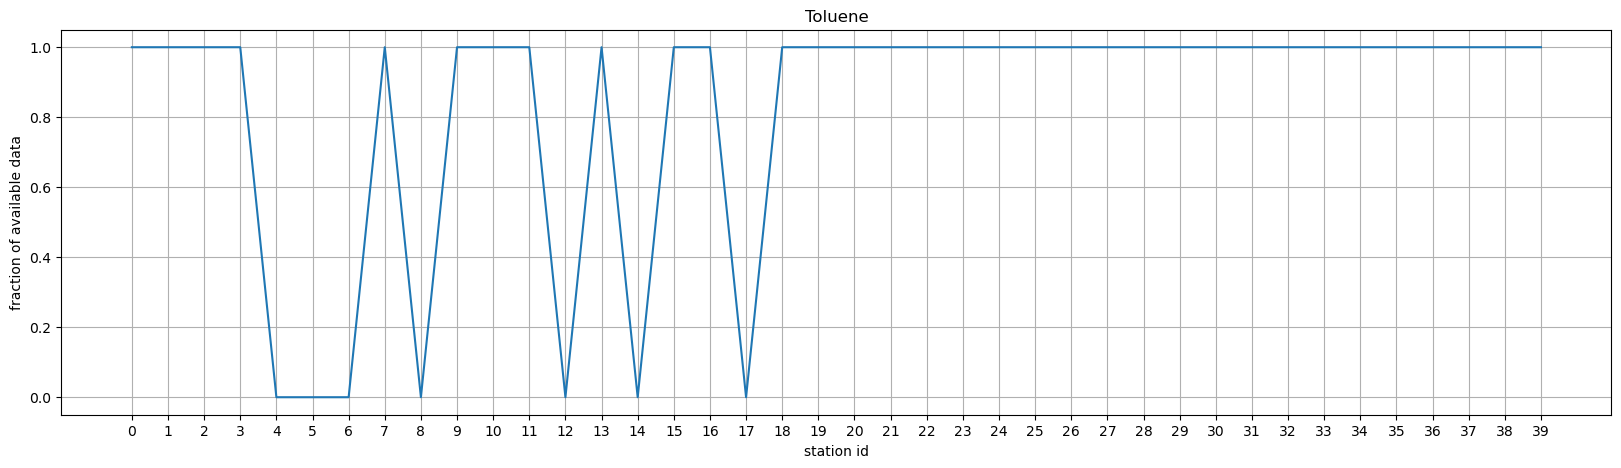

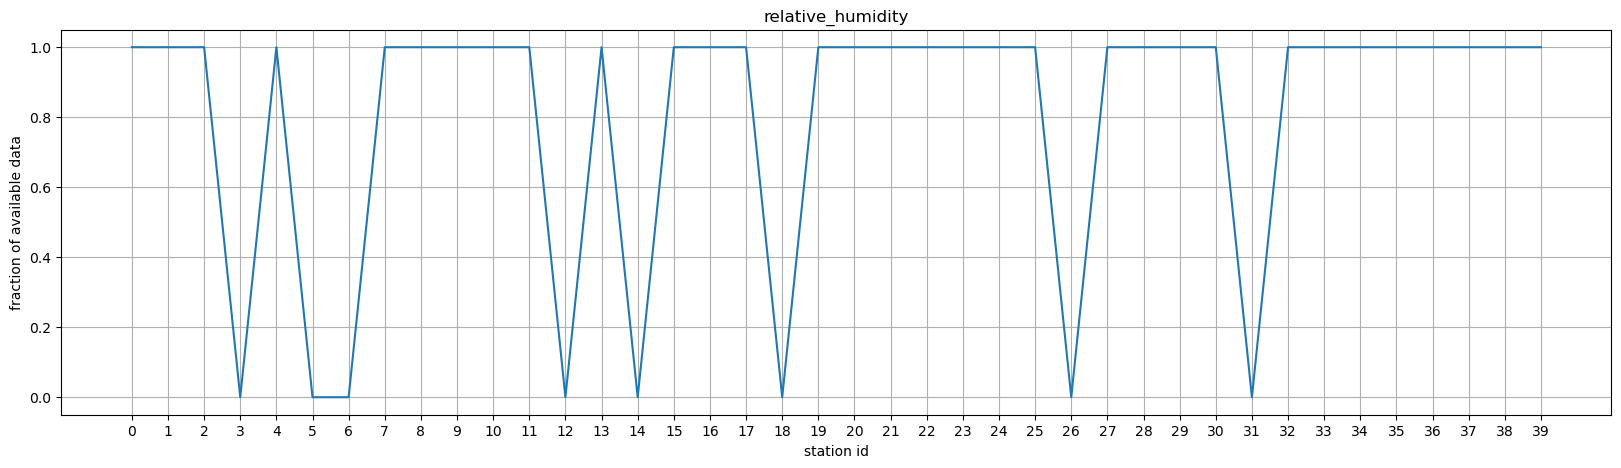

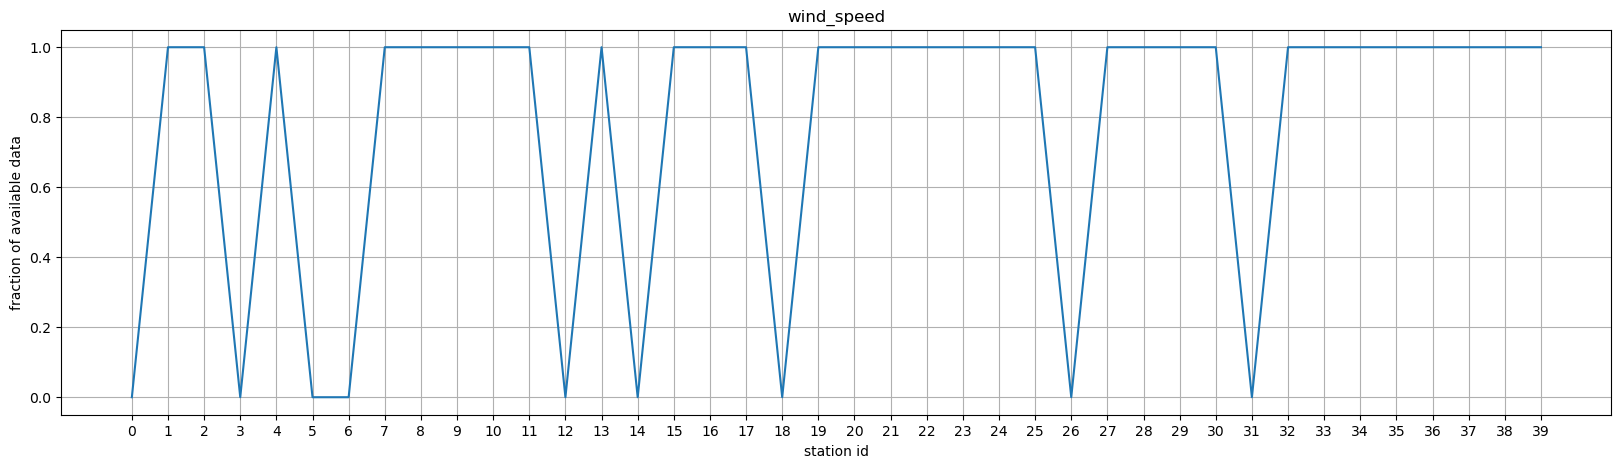

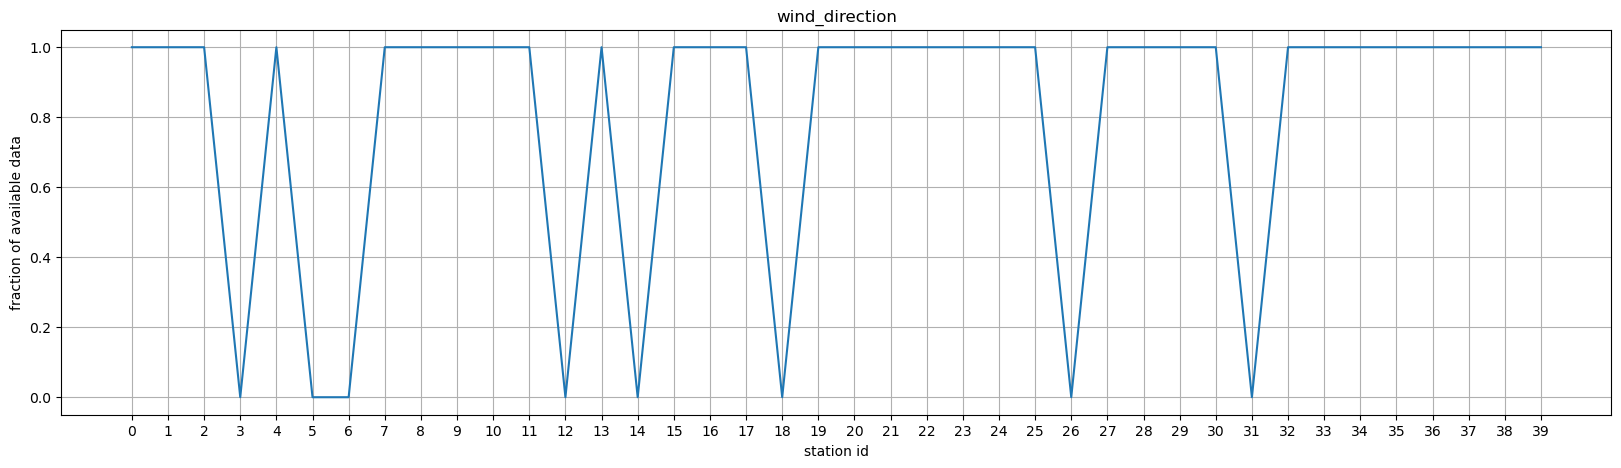

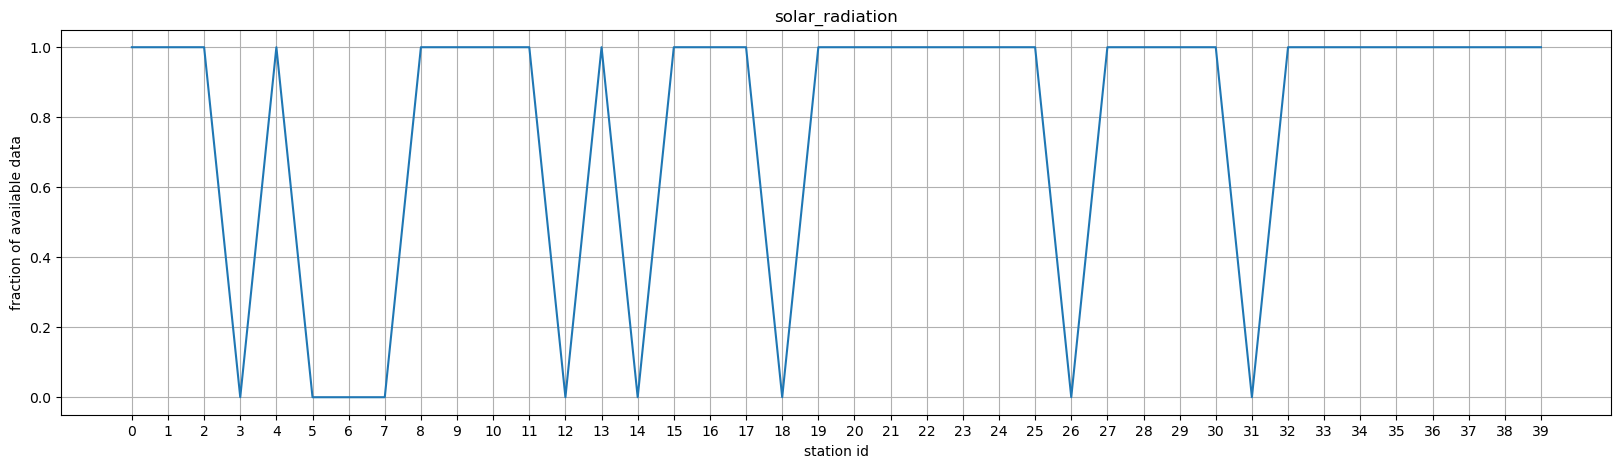

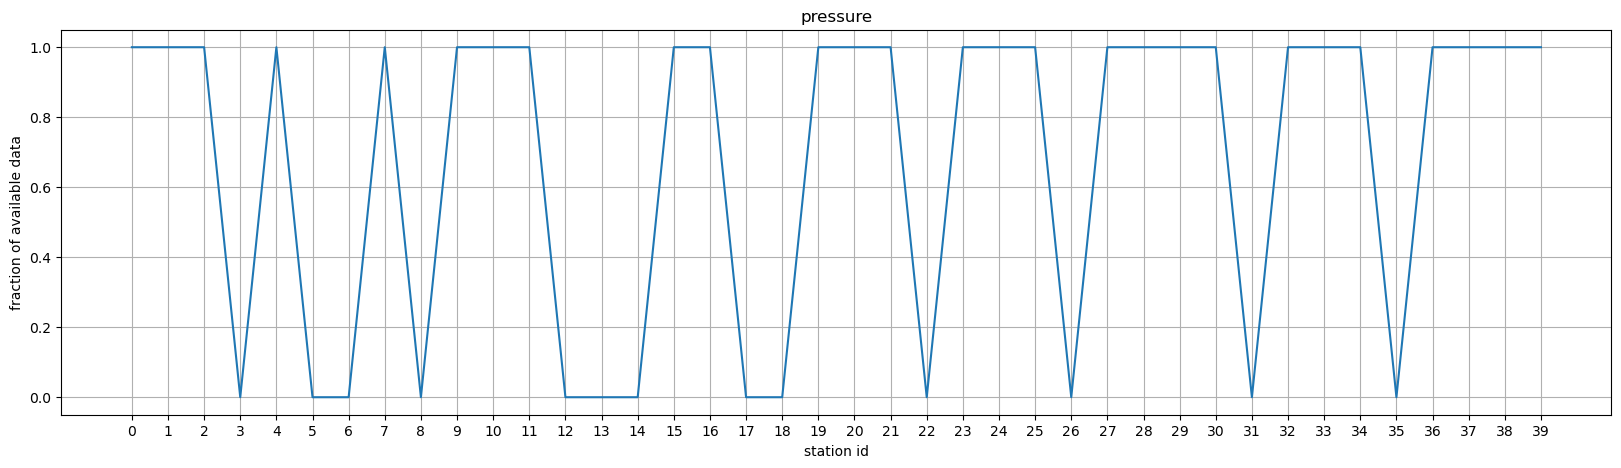

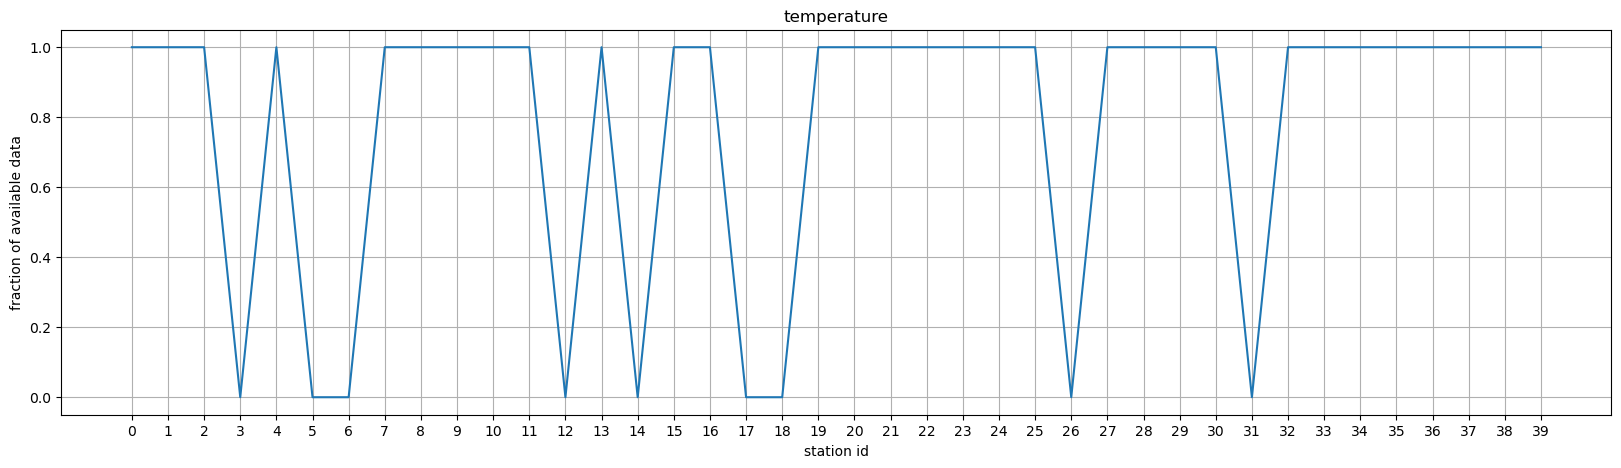

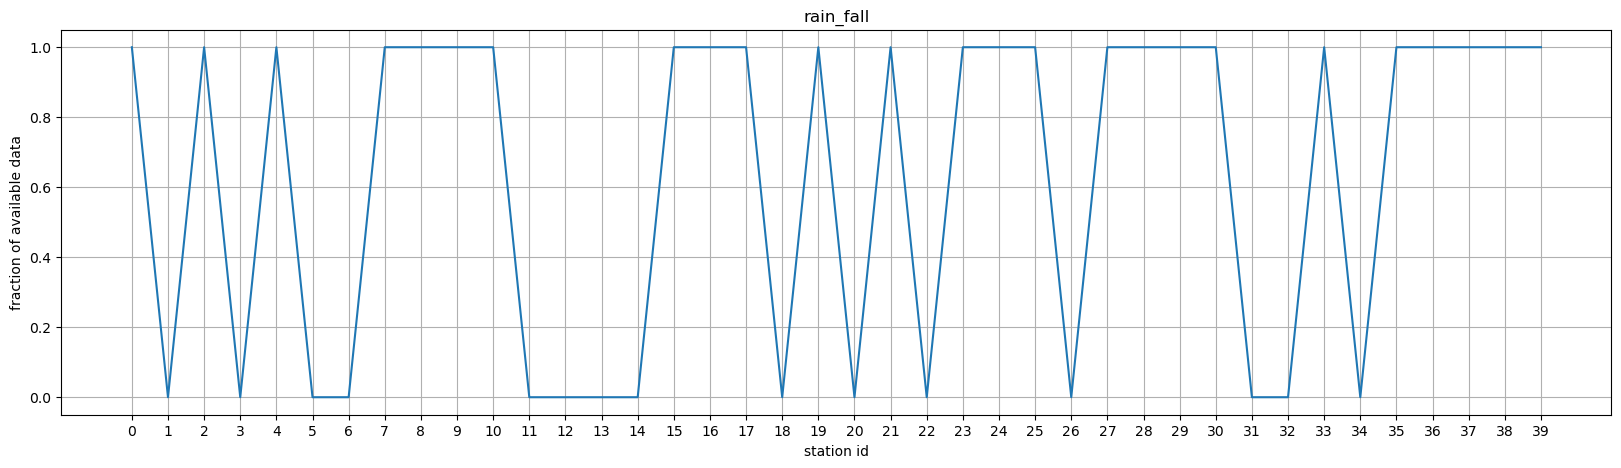

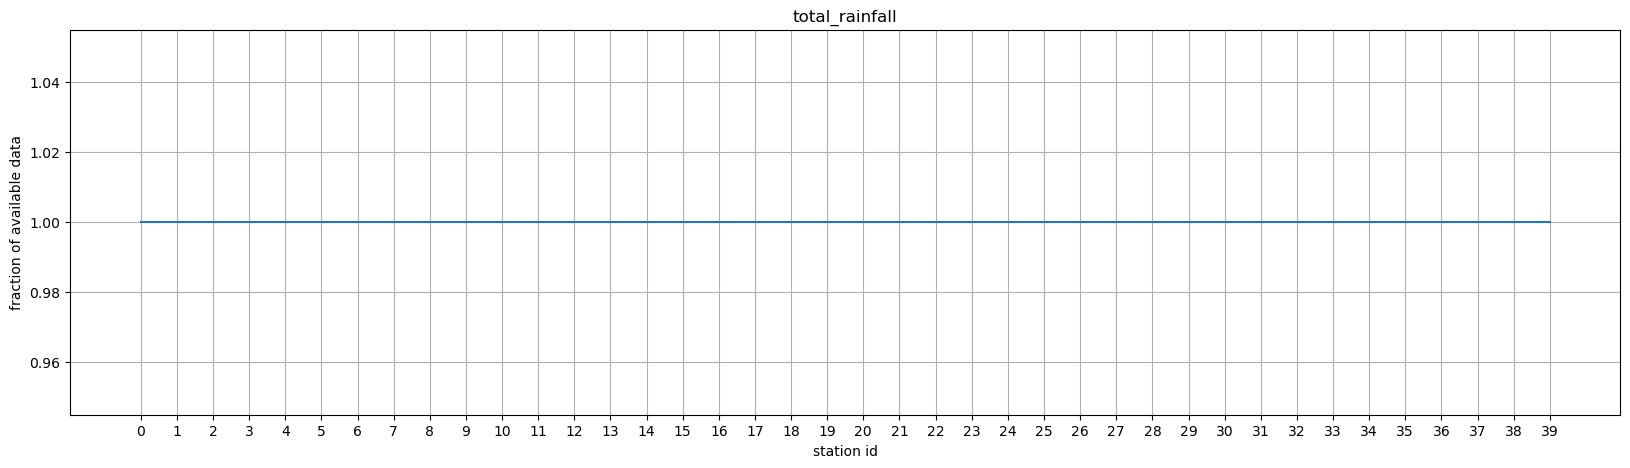

In [17]:
for i in values.keys():
    plt.figure(figsize=(20,5));
    plt.plot([j[1] for j in values[i]], [j[0] for j in values[i]])
    plt.title(i)
    plt.ylabel('fraction of available data')
    plt.xlabel('station id')
    plt.xticks([j for j in np.sort(df.station.unique())])
    plt.grid(True)
    plt.show()

In [18]:
filled_df.columns

Index(['station', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
       'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'relative_humidity',
       'wind_speed', 'wind_direction', 'solar_radiation', 'pressure',
       'temperature', 'rain_fall', 'total_rainfall', 'latitude', 'longitude',
       'datetime', 'filled'],
      dtype='object')

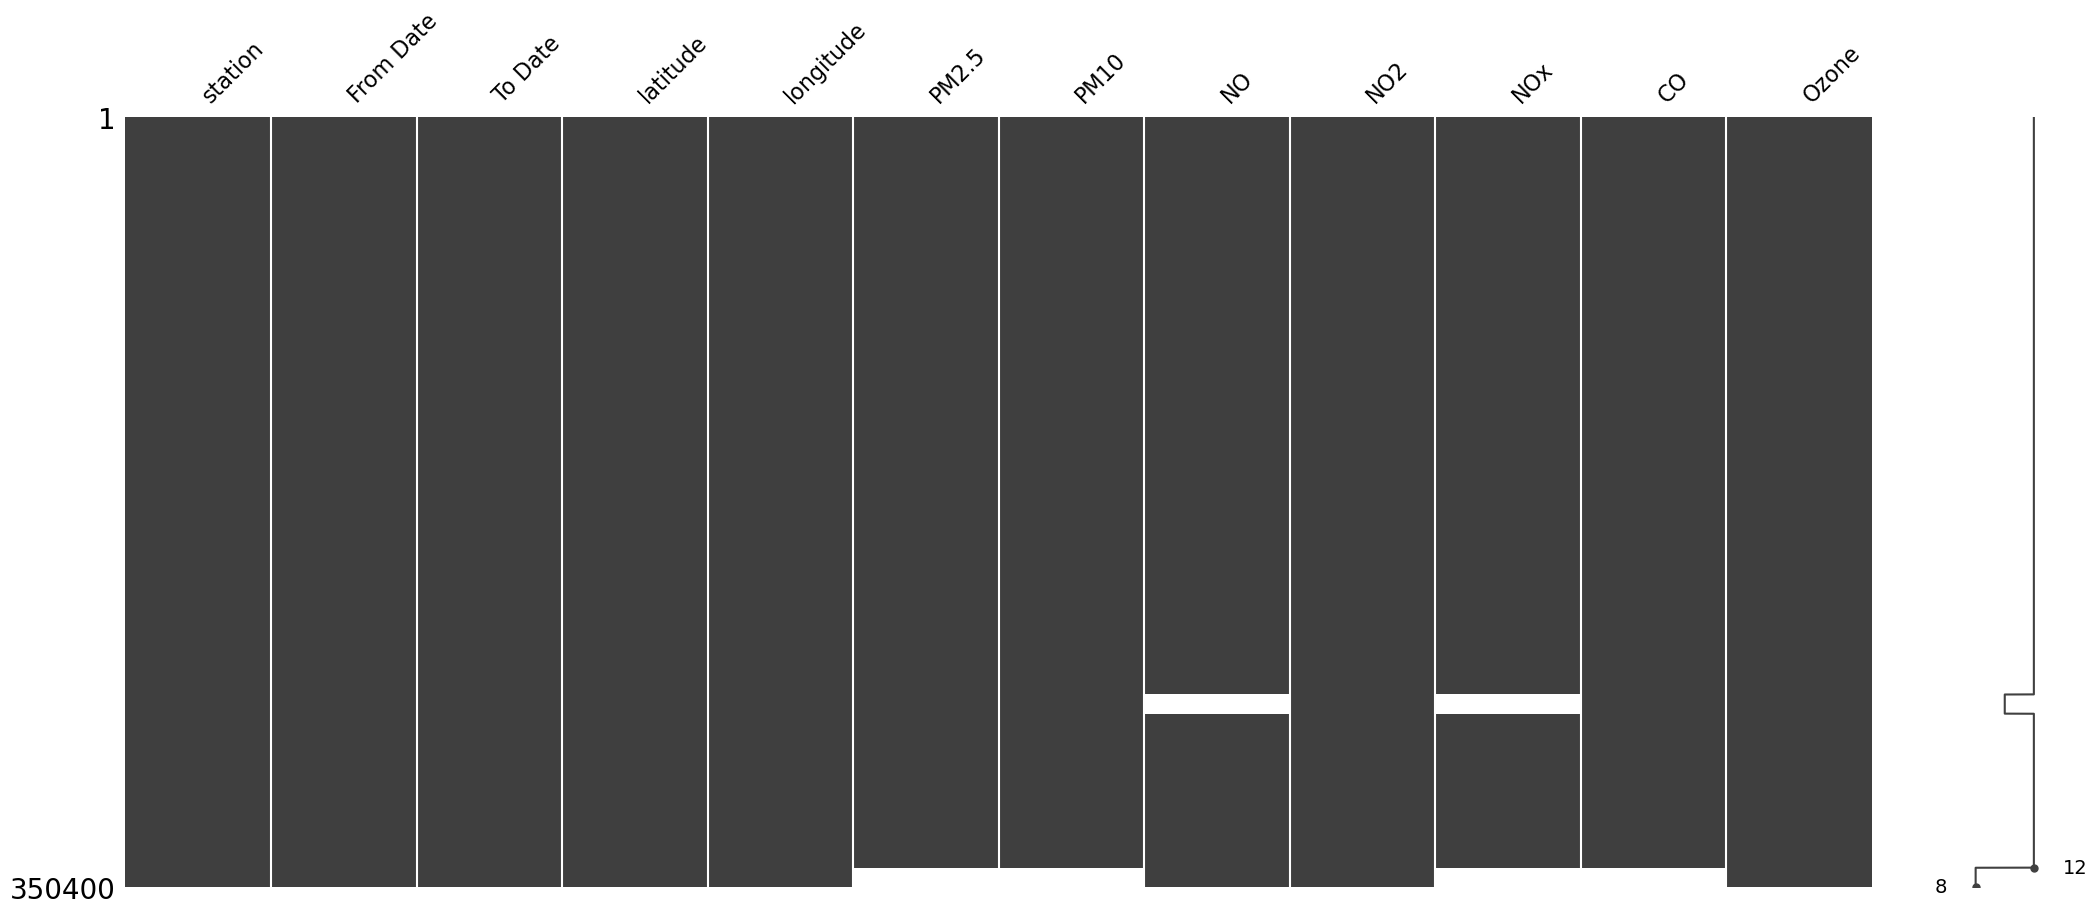

In [28]:
msno.matrix(final_df)  # Matrix plot
plt.show()


In [29]:
final_df.dropna(inplace=True)

In [30]:
len(final_df.station.unique())

38

In [23]:
final_df = filled_df[['station','From Date', 'To Date', 'latitude', 'longitude', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'Ozone']]

In [24]:
final_df['station'] = le.inverse_transform(final_df['station'])

In [25]:
len(df["From Date"].unique())

8760

In [31]:
final_df.isna().sum()

station      0
From Date    0
To Date      0
latitude     0
longitude    0
PM2.5        0
PM10         0
NO           0
NO2          0
NOx          0
CO           0
Ozone        0
dtype: int64

In [32]:
final_df.to_csv('del.csv')